# 3D-BPP

## Pre-requisites

In [4]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import sys
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

sys.path.append('src/')
import config, dataset, main, utils, bins


<IPython.core.display.Javascript object>

In [5]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [6]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [7]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


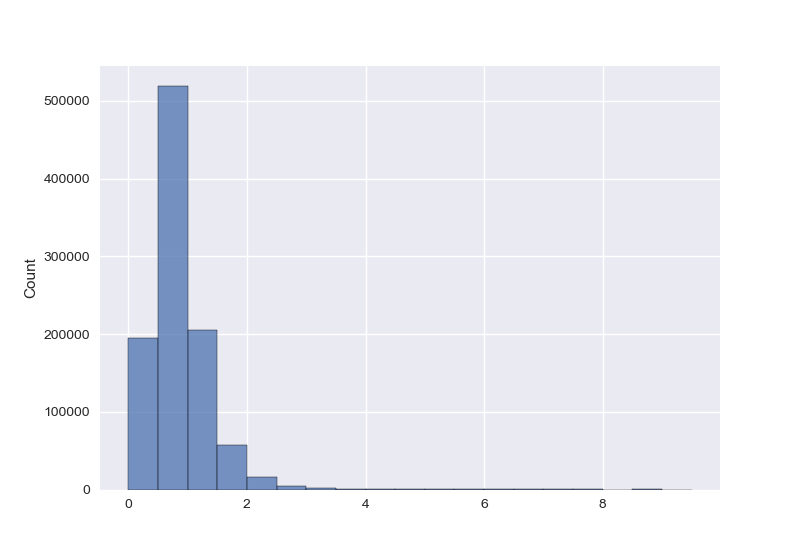

<IPython.core.display.Javascript object>

In [8]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


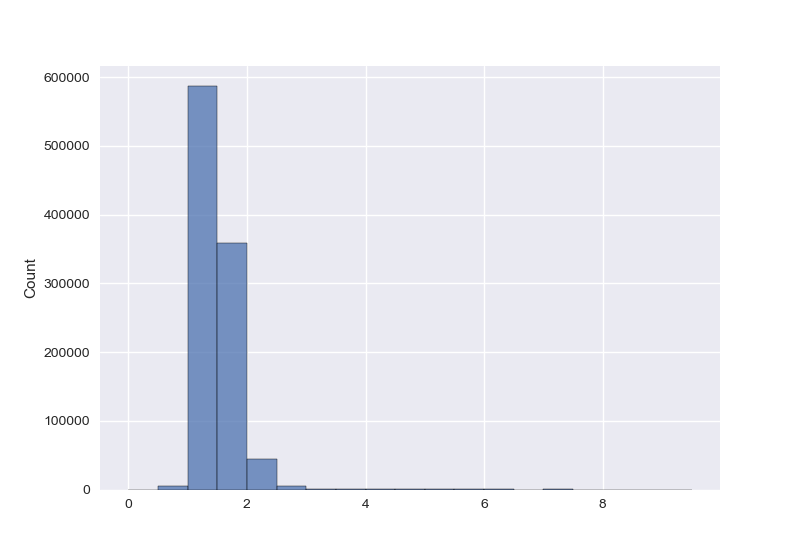

<IPython.core.display.Javascript object>

In [9]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


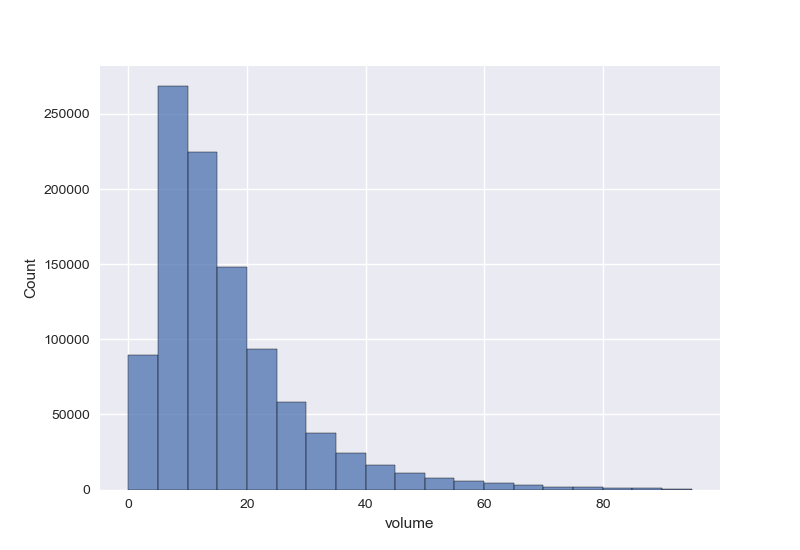

<IPython.core.display.Javascript object>

In [10]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


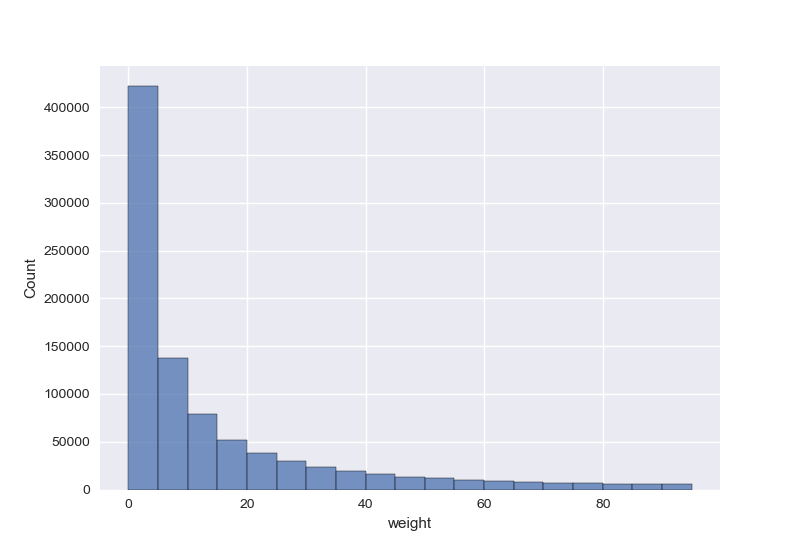

<IPython.core.display.Javascript object>

In [11]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


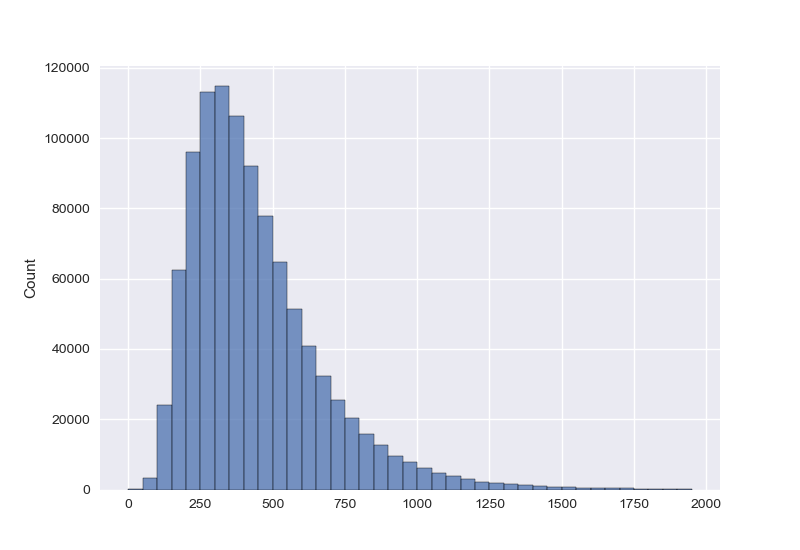

<IPython.core.display.Javascript object>

In [12]:
plt.figure()
sns.histplot(
    product_dataset.products.width * product_dataset.products.depth / 100,
    bins=np.arange(0, 2000, 50),
)
plt.show()

### Order

In [13]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [68]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [69]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [11]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,353,0,0,343,263,411,0
1,1,0,0,0,294,136,440,0
2,2,0,136,0,180,57,234,0
3,3,0,193,0,176,100,225,0
4,4,180,136,0,173,179,248,0
5,5,0,315,0,202,210,349,0
6,6,0,525,0,366,256,654,0
7,7,366,263,0,277,192,416,0
8,8,643,263,0,286,162,450,0
9,9,929,0,0,249,237,318,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


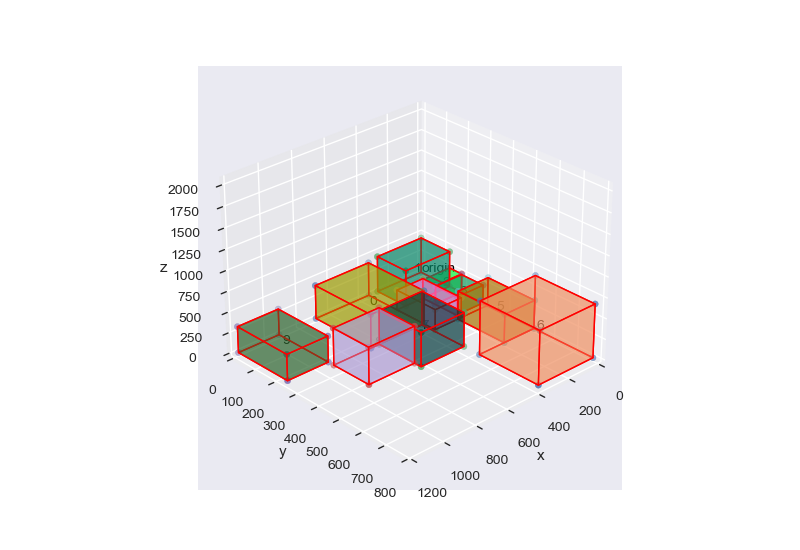

<IPython.core.display.Javascript object>

In [12]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

In [74]:
order.to_csv("test_order.csv")

<IPython.core.display.Javascript object>

In [71]:
mr_layer_pool = main.maxrects_procedure(order)
mr_layer_pool.to_dataframe()

2021-07-31 00:10:14.895 | INFO     | main:maxrects_procedure:150 - Starting Maxrects procedure
2021-07-31 00:10:14.897 | INFO     | main:maxrects_procedure:161 - Maxrects iteration 1/1
2021-07-31 00:10:14.898 | INFO     | superitems:gen_superitems:530 - Generating Superitems
2021-07-31 00:10:14.903 | DEBUG    | superitems:_gen_single_items_superitems:556 - Generated 50 SingleItemSuperitems
2021-07-31 00:10:14.904 | DEBUG    | superitems:_gen_superitems_vertical:656 - Generated 34 Wide VerticalSuperitems
2021-07-31 00:10:14.905 | DEBUG    | superitems:_gen_superitems_vertical:658 - Generated 14 Deep VerticalSuperitems
2021-07-31 00:10:14.906 | INFO     | superitems:gen_superitems:547 - Generated 98 Superitems
2021-07-31 00:10:14.907 | INFO     | main:maxrects_warm_start:43 - Computing MR layers
2021-07-31 00:10:14.933 | DEBUG    | main:maxrects_warm_start:51 - No height groups found, fallback to standard procedure
2021-07-31 00:10:14.933 | INFO     | main:maxrects_warm_start:58 - Proces

2021-07-31 00:10:15.028 | ERROR    | layers:get_items_dims:54 - Item repetition in the same layer, Items id:[23]
2021-07-31 00:10:15.030 | ERROR    | layers:get_items_coords:40 - Item repetition in the same layer, Items id:[4]
2021-07-31 00:10:15.032 | ERROR    | layers:get_items_coords:40 - Item repetition in the same layer, Items id:[18]
2021-07-31 00:10:15.032 | ERROR    | layers:get_items_coords:40 - Item repetition in the same layer, Items id:[5, 29]
2021-07-31 00:10:15.033 | ERROR    | layers:get_items_coords:40 - Item repetition in the same layer, Items id:[22]
2021-07-31 00:10:15.036 | ERROR    | layers:get_items_coords:40 - Item repetition in the same layer, Items id:[26]
2021-07-31 00:10:15.036 | ERROR    | layers:get_items_coords:40 - Item repetition in the same layer, Items id:[34, 17]
2021-07-31 00:10:15.037 | ERROR    | layers:get_items_coords:40 - Item repetition in the same layer, Items id:[12]
2021-07-31 00:10:15.038 | ERROR    | layers:get_items_coords:40 - Item repet

""


<IPython.core.display.Javascript object>

2021-07-30 23:01:19.586 | DEBUG    | maxrects:maxrects_multiple_layers:15 - Starting MR-Multiple-Layers
2021-07-30 23:01:19.601 | DEBUG    | maxrects:maxrects_multiple_layers:56 - MR-Multiple-Layers Generated layers: 3 from superitems: 50


<IPython.core.display.Javascript object>


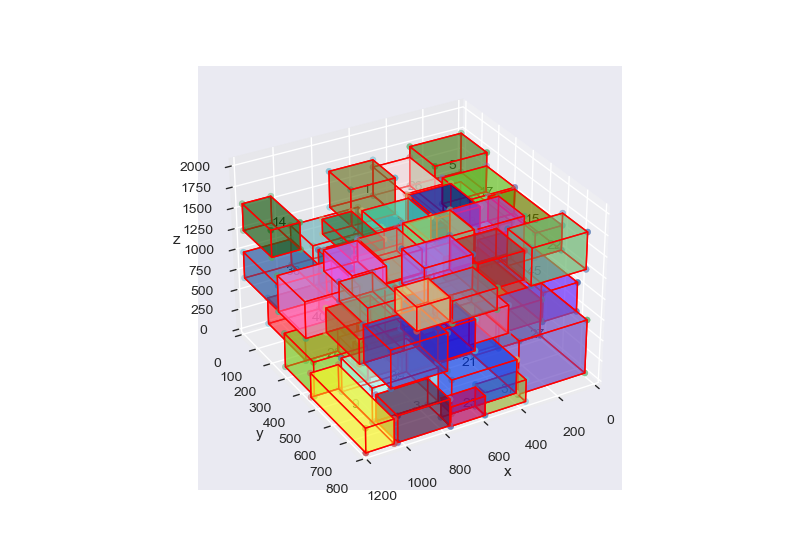

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [58]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

In [63]:
a = dict()
a[1] = 2
a[4] = 5
a[3]


KeyError: 3

<IPython.core.display.Javascript object>

## Column generation

In [59]:
cg_layer_pool, cg_bins_lbs = main.column_generation_procedure(
    order, use_height_groups=False
)
cg_layer_pool.to_dataframe()

2021-07-30 23:01:25.348 | INFO     | main:column_generation_procedure:221 - Starting Column generation procedure
2021-07-30 23:01:25.349 | INFO     | main:column_generation_procedure:232 - CG iteration 1/1
2021-07-30 23:01:25.350 | INFO     | superitems:gen_superitems:529 - Generating Superitems
2021-07-30 23:01:25.357 | DEBUG    | superitems:_gen_single_items_superitems:555 - Generated 50 SingleItemSuperitems
2021-07-30 23:01:25.358 | INFO     | main:column_generation_procedure:257 - Processing height group 1/1
2021-07-30 23:01:25.359 | INFO     | main:maxrects_warm_start:43 - Computing MR layers
2021-07-30 23:01:25.362 | DEBUG    | main:maxrects_warm_start:51 - No height groups found, fallback to standard procedure
2021-07-30 23:01:25.363 | INFO     | main:maxrects_warm_start:58 - Processing height group 1/1
2021-07-30 23:01:25.364 | DEBUG    | maxrects:maxrects_multiple_layers:15 - Starting MR-Multiple-Layers
2021-07-30 23:01:25.383 | DEBUG    | maxrects:maxrects_multiple_layers:56 

FEASIBILITY:  25


2021-07-30 23:01:35.496 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02445348
2021-07-30 23:01:35.501 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:01:35.503 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 24
2021-07-30 23:01:35.504 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0021186440677966097 reward about selecting superitems with zero dual
2021-07-30 23:01:35.507 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:01:35.513 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.036016949152, SP-NP time: 0.009Num selected Superitems: 24
2021-07-30 23:01:35.514 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  24


2021-07-30 23:01:40.554 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0321429030000004
2021-07-30 23:01:40.561 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:01:40.563 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 23
2021-07-30 23:01:40.563 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0021186440677966097 reward about selecting superitems with zero dual
2021-07-30 23:01:40.567 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:01:40.577 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0338983050844, SP-NP time: 0.01Num selected Superitems: 23
2021-07-30 23:01:40.578 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  23


2021-07-30 23:01:40.822 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.232719213
2021-07-30 23:01:40.824 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:01:40.844 | INFO     | column_generation:column_generation:528 - CG iteration2/100
2021-07-30 23:01:40.845 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:01:40.848 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 54 variables, 50 constraints, in 48 iterations
2021-07-30 23:01:40.850 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.   0.   0.   0.   0.   0.   0.   0.   0. 248.   0.   0. 323. 132.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 349.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 406.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 257.]
RMP time: 0.004
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

FEASIBILITY:  28


2021-07-30 23:01:50.947 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022354503000001
2021-07-30 23:01:50.951 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:01:50.952 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 26
2021-07-30 23:01:50.952 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0021929824561403508 reward about selecting superitems with zero dual
2021-07-30 23:01:50.957 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:01:50.961 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0438596491226, SP-NP time: 0.008Num selected Superitems: 26
2021-07-30 23:01:50.962 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  26


2021-07-30 23:01:56.014 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.041426085
2021-07-30 23:01:56.022 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:01:56.023 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 25
2021-07-30 23:01:56.025 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0021929824561403508 reward about selecting superitems with zero dual
2021-07-30 23:01:56.030 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:01:56.035 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0416666666665, SP-NP time: 0.014Num selected Superitems: 25
2021-07-30 23:01:56.036 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  25


2021-07-30 23:01:56.378 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.330381023
2021-07-30 23:01:56.380 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:01:56.395 | INFO     | column_generation:column_generation:528 - CG iteration3/100
2021-07-30 23:01:56.396 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:01:56.400 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 55 variables, 50 constraints, in 51 iterations
2021-07-30 23:01:56.403 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [371.   0.   0.   0.   0. 204. 182.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 277.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 209. 195. 277.   0.   0.]
RMP time: 0.006
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

FEASIBILITY:  27


2021-07-30 23:02:06.504 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028787791
2021-07-30 23:02:06.510 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:02:06.511 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 26
2021-07-30 23:02:06.511 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 23:02:06.515 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:02:06.522 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0451306413306, SP-NP time: 0.01Num selected Superitems: 26
2021-07-30 23:02:06.524 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  26


2021-07-30 23:02:11.549 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01577487
2021-07-30 23:02:11.556 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:02:11.558 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 25
2021-07-30 23:02:11.559 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 23:02:11.562 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:02:11.568 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0427553444183, SP-NP time: 0.011Num selected Superitems: 25
2021-07-30 23:02:11.570 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  25


2021-07-30 23:02:16.603 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022214133
2021-07-30 23:02:16.609 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:02:16.611 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 24
2021-07-30 23:02:16.612 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 23:02:16.615 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:02:16.621 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.040380047506, SP-NP time: 0.01Num selected Superitems: 24
2021-07-30 23:02:16.622 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  24


2021-07-30 23:02:16.961 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.329964454
2021-07-30 23:02:16.962 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:02:16.969 | INFO     | column_generation:column_generation:528 - CG iteration4/100
2021-07-30 23:02:16.970 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:02:16.973 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 56 variables, 50 constraints, in 52 iterations
2021-07-30 23:02:16.974 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.   0.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 123.   0.  93. 441.   0.   0.   0.   0.   0. 349.   0.
   0.   0.  31.   0.   0. 456.   0.   0.   0.   0.   0. 213.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 0.003
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

FEASIBILITY:  24


2021-07-30 23:02:27.074 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018730945000001
2021-07-30 23:02:27.078 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:02:27.079 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 23
2021-07-30 23:02:27.080 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.001976284584980237 reward about selecting superitems with zero dual
2021-07-30 23:02:27.083 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:02:27.089 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0296442687745, SP-NP time: 0.008Num selected Superitems: 23
2021-07-30 23:02:27.091 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  23


2021-07-30 23:02:32.116 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017427553
2021-07-30 23:02:32.121 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:02:32.123 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:02:32.124 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.001976284584980237 reward about selecting superitems with zero dual
2021-07-30 23:02:32.126 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:02:32.131 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0276679841895, SP-NP time: 0.008Num selected Superitems: 22
2021-07-30 23:02:32.133 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:02:35.526 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 3.384123862
2021-07-30 23:02:35.527 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:02:35.539 | INFO     | column_generation:column_generation:528 - CG iteration5/100
2021-07-30 23:02:35.541 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:02:35.545 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 57 variables, 50 constraints, in 52 iterations
2021-07-30 23:02:35.547 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.   0.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 123.   0.   0.   0.   0.   0.   0.   0.   0. 349. 329.
   0.  93.   0.   0.   0.   0.   0. 487.   0.   0.   0.   0. 325.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 0.004
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

FEASIBILITY:  26


2021-07-30 23:02:45.626 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014166128
2021-07-30 23:02:45.631 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:02:45.632 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 25
2021-07-30 23:02:45.633 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00186219739292365 reward about selecting superitems with zero dual
2021-07-30 23:02:45.636 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:02:45.641 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0335195530727, SP-NP time: 0.008Num selected Superitems: 25
2021-07-30 23:02:45.643 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  25


2021-07-30 23:02:50.669 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018007175
2021-07-30 23:02:50.675 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:02:50.676 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 24
2021-07-30 23:02:50.677 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00186219739292365 reward about selecting superitems with zero dual
2021-07-30 23:02:50.679 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:02:50.685 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0316573556797, SP-NP time: 0.008Num selected Superitems: 24
2021-07-30 23:02:50.686 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  24


2021-07-30 23:02:50.873 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:02:50.889 | INFO     | column_generation:column_generation:528 - CG iteration6/100
2021-07-30 23:02:50.890 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:02:50.894 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 58 variables, 50 constraints, in 55 iterations
2021-07-30 23:02:50.896 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.  156.5   0.    0.  288.    9.   44.5 394.    0.    0.  273.    0.
   0.    0.    0.    0.    0.    0.  292.    0.    0.   42.5   0.    0.
   0.    0.   42.5   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  173.    0.    0.    0.    0.    0.    0.    0.
   0.    0. ]
RMP time: 0.005
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

FEASIBILITY:  24


2021-07-30 23:03:01.009 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016256942
2021-07-30 23:03:01.014 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:01.015 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 23
2021-07-30 23:03:01.016 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0022522522522522522 reward about selecting superitems with zero dual
2021-07-30 23:03:01.019 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:03:01.025 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.029279279279, SP-NP time: 0.009Num selected Superitems: 23
2021-07-30 23:03:01.026 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  23


2021-07-30 23:03:06.073 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0374802800000005
2021-07-30 23:03:06.082 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:06.084 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:03:06.085 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0022522522522522522 reward about selecting superitems with zero dual
2021-07-30 23:03:06.088 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:03:06.097 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.027027027027, SP-NP time: 0.012Num selected Superitems: 22
2021-07-30 23:03:06.098 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:03:09.939 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 3.8324454360000004
2021-07-30 23:03:09.940 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:03:09.951 | INFO     | column_generation:column_generation:528 - CG iteration7/100
2021-07-30 23:03:09.952 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:03:09.955 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 59 variables, 50 constraints, in 55 iterations
2021-07-30 23:03:09.957 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.           0.           0.           0.           0.
   9.         191.66666667   0.           0.           0.
   0.           0.           0.           0.           0.
   0.         282.33333333   0.           0.         282.33333333
   0.         189.66666667   0.           0.           0.
   0.         189.666666

FEASIBILITY:  23


2021-07-30 23:03:20.052 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024221038
2021-07-30 23:03:20.059 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:20.061 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:03:20.062 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.002876318312559923 reward about selecting superitems with zero dual
2021-07-30 23:03:20.065 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:03:20.075 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0373921380633, SP-NP time: 0.012Num selected Superitems: 22
2021-07-30 23:03:20.077 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  22


2021-07-30 23:03:25.230 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020947378000001
2021-07-30 23:03:25.234 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:25.235 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 24
2021-07-30 23:03:25.237 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0021691973969631233 reward about selecting superitems with zero dual
2021-07-30 23:03:25.239 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:03:25.245 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0281995661603, SP-NP time: 0.008Num selected Superitems: 24
2021-07-30 23:03:25.246 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  24


2021-07-30 23:03:30.277 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022762043
2021-07-30 23:03:30.282 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:30.283 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 23
2021-07-30 23:03:30.284 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0021691973969631233 reward about selecting superitems with zero dual
2021-07-30 23:03:30.286 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:03:30.292 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0260303687633, SP-NP time: 0.008Num selected Superitems: 23
2021-07-30 23:03:30.293 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  23


2021-07-30 23:03:30.717 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.413345664
2021-07-30 23:03:30.719 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:03:30.737 | INFO     | column_generation:column_generation:528 - CG iteration9/100
2021-07-30 23:03:30.738 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:03:30.743 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 61 variables, 50 constraints, in 57 iterations
2021-07-30 23:03:30.745 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.     70.375   0.      0.     70.625   9.      2.      0.     72.375
   0.      0.    437.      0.    239.5     0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
 313.75    0.      0.      0.      0.      0.     72.375   0.      0.
   0.      0.      0.      0.     98.75    0. 

FEASIBILITY:  24


2021-07-30 23:03:40.855 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017922952
2021-07-30 23:03:40.861 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:40.862 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 23
2021-07-30 23:03:40.863 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.002053388090349076 reward about selecting superitems with zero dual
2021-07-30 23:03:40.866 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:03:40.871 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0225872689937, SP-NP time: 0.009Num selected Superitems: 23
2021-07-30 23:03:40.872 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  23


2021-07-30 23:03:45.903 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021766584000001
2021-07-30 23:03:45.909 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:45.910 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:03:45.910 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.002053388090349076 reward about selecting superitems with zero dual
2021-07-30 23:03:45.913 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:03:45.918 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0205338809033, SP-NP time: 0.008Num selected Superitems: 22
2021-07-30 23:03:45.919 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:03:47.114 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.185796641
2021-07-30 23:03:47.115 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:03:47.125 | INFO     | column_generation:column_generation:528 - CG iteration10/100
2021-07-30 23:03:47.126 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:03:47.130 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 62 variables, 50 constraints, in 54 iterations
2021-07-30 23:03:47.132 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.           0.           0.           0.           0.
  76.14285714   0.           0.           0.           0.
   0.           0.           0.           0.           0.
 295.           0.          42.28571429 147.28571429   0.
   0.           0.           0.           0.         177.
   0.           0.         247.1428571

FEASIBILITY:  24


2021-07-30 23:03:57.241 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027913744
2021-07-30 23:03:57.246 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:03:57.248 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 23
2021-07-30 23:03:57.249 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.002898550724637681 reward about selecting superitems with zero dual
2021-07-30 23:03:57.252 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:03:57.259 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0289855072463, SP-NP time: 0.009Num selected Superitems: 23
2021-07-30 23:03:57.261 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  23


2021-07-30 23:04:00.988 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 3.7165921330000002
2021-07-30 23:04:00.989 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:04:00.998 | INFO     | column_generation:column_generation:528 - CG iteration11/100
2021-07-30 23:04:00.999 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:04:01.002 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 63 variables, 50 constraints, in 60 iterations
2021-07-30 23:04:01.003 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  4.33333333   0.           0.           0.           0.
   9.           0.          50.91666667   0.           0.
   0.          41.91666667   0.           0.           0.
   0.           0.           2.33333333   0.          41.91666667
   0.           0.         440.           0.           0.
   0.           0.     

FEASIBILITY:  22


2021-07-30 23:04:11.095 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014876347
2021-07-30 23:04:11.100 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:04:11.100 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:04:11.101 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0015311981625622051 reward about selecting superitems with zero dual
2021-07-30 23:04:11.104 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:04:11.110 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0122495853004, SP-NP time: 0.007Num selected Superitems: 21
2021-07-30 23:04:11.111 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:04:11.540 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.420084628
2021-07-30 23:04:11.542 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:04:11.558 | INFO     | column_generation:column_generation:528 - CG iteration12/100
2021-07-30 23:04:11.560 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:04:11.564 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 64 variables, 50 constraints, in 59 iterations
2021-07-30 23:04:11.566 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  4.54545455   0.           0.           0.           0.
 306.           0.           0.           0.         297.
   0.         224.31818182   0.           2.54545455   0.
   0.          53.31818182   0.         161.04545455   0.
 131.27272727   0.           0.           0.           0.
   0.           0.           0.       

FEASIBILITY:  23


2021-07-30 23:04:21.658 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014976155
2021-07-30 23:04:21.665 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:04:21.667 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:04:21.668 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0028089887640449437 reward about selecting superitems with zero dual
2021-07-30 23:04:21.671 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:04:21.678 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0252808988764, SP-NP time: 0.012Num selected Superitems: 22
2021-07-30 23:04:21.680 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:04:26.717 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028950519
2021-07-30 23:04:26.723 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:04:26.724 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:04:26.725 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0028089887640449437 reward about selecting superitems with zero dual
2021-07-30 23:04:26.729 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:04:26.736 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0224719101122, SP-NP time: 0.011Num selected Superitems: 21
2021-07-30 23:04:26.737 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:04:31.773 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027139518
2021-07-30 23:04:31.779 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:04:31.780 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:04:31.781 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0028089887640449437 reward about selecting superitems with zero dual
2021-07-30 23:04:31.786 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:04:31.792 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0196629213483, SP-NP time: 0.011Num selected Superitems: 20
2021-07-30 23:04:31.794 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:04:34.117 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 2.3123696440000003
2021-07-30 23:04:34.118 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:04:34.130 | INFO     | column_generation:column_generation:528 - CG iteration13/100
2021-07-30 23:04:34.132 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:04:34.135 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 65 variables, 50 constraints, in 58 iterations
2021-07-30 23:04:34.136 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0000000000002
Duals: [  0.           0.           0.           0.         184.29032258
   9.           0.         226.1827957   86.07526882   0.
   0.          16.78494624   0.           0.           0.
   0.          99.61290323 286.31182796  60.12903226 115.72043011
  28.86021505   0.           0.           0.           0.
   

FEASIBILITY:  19


2021-07-30 23:04:42.225 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 3.017164483
2021-07-30 23:04:42.226 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:04:42.236 | INFO     | column_generation:column_generation:528 - CG iteration14/100
2021-07-30 23:04:42.236 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:04:42.239 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 66 variables, 50 constraints, in 60 iterations
2021-07-30 23:04:42.240 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.           0.           0.           0.          49.57142857
   9.         268.          42.57142857  88.           0.
   0.          28.57142857   0.         210.85714286   0.
   0.           0.          55.14285714   0.           0.
   0.           0.         118.           0.           0.
   0.           0.           0

FEASIBILITY:  24


2021-07-30 23:04:52.341 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02529365
2021-07-30 23:04:52.348 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:04:52.349 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 23
2021-07-30 23:04:52.350 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0022187004754358162 reward about selecting superitems with zero dual
2021-07-30 23:04:52.353 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:04:52.360 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0221870047544, SP-NP time: 0.011Num selected Superitems: 23
2021-07-30 23:04:52.363 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  23


2021-07-30 23:04:57.393 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0206881
2021-07-30 23:04:57.401 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:04:57.403 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:04:57.404 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0022187004754358162 reward about selecting superitems with zero dual
2021-07-30 23:04:57.408 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:04:57.417 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0199683042788, SP-NP time: 0.013Num selected Superitems: 22
2021-07-30 23:04:57.418 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:05:02.453 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021647155
2021-07-30 23:05:02.458 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:02.459 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:05:02.460 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0022187004754358162 reward about selecting superitems with zero dual
2021-07-30 23:05:02.464 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:05:02.472 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0177496038034, SP-NP time: 0.009Num selected Superitems: 21
2021-07-30 23:05:02.474 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:05:03.968 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.485261127
2021-07-30 23:05:03.969 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:05:03.981 | INFO     | column_generation:column_generation:528 - CG iteration15/100
2021-07-30 23:05:03.982 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:05:03.986 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 67 variables, 50 constraints, in 61 iterations
2021-07-30 23:05:03.988 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.           0.           0.           0.           0.
   9.           0.         171.04639175   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           8.46391753   0.           0.
 121.69072165   0.           0.           0.           0.
   0.         201.22680412  51.0670103

FEASIBILITY:  18


2021-07-30 23:05:14.094 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02229958
2021-07-30 23:05:14.102 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:14.105 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:05:14.106 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00331029775616415 reward about selecting superitems with zero dual
2021-07-30 23:05:14.112 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:05:14.121 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0066205955122, SP-NP time: 0.015Num selected Superitems: 17
2021-07-30 23:05:14.124 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:05:19.159 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022216520000001
2021-07-30 23:05:19.164 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:19.165 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:05:19.166 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00331029775616415 reward about selecting superitems with zero dual
2021-07-30 23:05:19.170 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:05:19.175 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0033102977561, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:05:19.177 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:05:20.223 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.038715023
2021-07-30 23:05:20.224 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:05:20.238 | INFO     | column_generation:column_generation:528 - CG iteration16/100
2021-07-30 23:05:20.239 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:05:20.242 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 68 variables, 50 constraints, in 61 iterations
2021-07-30 23:05:20.244 | DEBUG    | column_generation:column_generation:538 - RMP objective 1715.0
Duals: [  0.           0.           0.           0.          45.00757576
  36.93181818  34.87121212  51.33712121   0.           0.
   0.           0.           0.         126.98484848   0.
   0.           0.           0.           0.           0.
   0.         184.44318182   0.           0.           0.
   0.           0.         139

FEASIBILITY:  19


2021-07-30 23:05:30.341 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019653639
2021-07-30 23:05:30.347 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:30.349 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:05:30.350 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0027841346508758425 reward about selecting superitems with zero dual
2021-07-30 23:05:30.354 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:05:30.362 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0055682693012, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:05:30.364 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:05:35.394 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020014588
2021-07-30 23:05:35.401 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:35.403 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:05:35.404 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0027841346508758425 reward about selecting superitems with zero dual
2021-07-30 23:05:35.407 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:05:35.414 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1715.0027841346505, SP-NP time: 0.011Num selected Superitems: 17
2021-07-30 23:05:35.415 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-0

FEASIBILITY:  17


2021-07-30 23:05:40.552 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013060291
2021-07-30 23:05:40.558 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:40.559 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:05:40.560 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00346443053423094 reward about selecting superitems with zero dual
2021-07-30 23:05:40.563 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:05:40.569 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1662.0681818181822, SP-NP time: 0.01Num selected Superitems: 14
2021-07-30 23:05:40.570 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:05:45.598 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0220357490000005
2021-07-30 23:05:45.604 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:45.606 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:05:45.607 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00346443053423094 reward about selecting superitems with zero dual
2021-07-30 23:05:45.610 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:05:45.617 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1628.5681818181818, SP-NP time: 0.011Num selected Superitems: 13
2021-07-30 23:05:45.618 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:05:45.889 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.26431419100000003
2021-07-30 23:05:45.890 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:05:45.903 | INFO     | column_generation:column_generation:528 - CG iteration18/100
2021-07-30 23:05:45.904 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:05:45.908 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 70 variables, 50 constraints, in 76 iterations
2021-07-30 23:05:45.910 | DEBUG    | column_generation:column_generation:538 - RMP objective 1711.0579710144925
Duals: [  6.8236715    0.           0.           0.          23.57004831
   5.05797101 122.40096618   0.           0.           0.
   0.         116.28502415   0.           0.           0.
 255.34057971   0.           0.           0.         148.77536232
   0.          93.20289855  85.91062802   0.           0.
  

FEASIBILITY:  18


2021-07-30 23:05:56.008 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0183741930000005
2021-07-30 23:05:56.015 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:05:56.016 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:05:56.017 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0032750314450482967 reward about selecting superitems with zero dual
2021-07-30 23:05:56.019 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:05:56.024 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1711.057971014493, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:05:56.025 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:06:01.052 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019128345
2021-07-30 23:06:01.057 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:01.058 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:06:01.058 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0032750314450482967 reward about selecting superitems with zero dual
2021-07-30 23:06:01.063 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:06:01.068 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1710.1932367149761, SP-NP time: 0.01Num selected Superitems: 16
2021-07-30 23:06:01.069 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  16


2021-07-30 23:06:06.202 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.039786649000001
2021-07-30 23:06:06.209 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:06.211 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:06:06.213 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004349236891092604 reward about selecting superitems with zero dual
2021-07-30 23:06:06.216 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:06:06.223 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1643.4083769633507, SP-NP time: 0.011Num selected Superitems: 16
2021-07-30 23:06:06.224 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:06:11.251 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020943442
2021-07-30 23:06:11.257 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:11.258 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:06:11.259 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004349236891092604 reward about selecting superitems with zero dual
2021-07-30 23:06:11.262 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:06:11.268 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1626.7997382198953, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:06:11.269 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  15


2021-07-30 23:06:16.445 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025707363
2021-07-30 23:06:16.450 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:16.451 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:06:16.452 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004134798522810354 reward about selecting superitems with zero dual
2021-07-30 23:06:16.456 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:06:16.460 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1577.7643816254417, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:06:16.462 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:06:21.497 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027739171
2021-07-30 23:06:21.507 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:21.509 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:06:21.511 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004134798522810354 reward about selecting superitems with zero dual
2021-07-30 23:06:21.515 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:06:21.525 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1540.3683392226148, SP-NP time: 0.015Num selected Superitems: 15
2021-07-30 23:06:21.527 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  15


2021-07-30 23:06:26.680 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020445683
2021-07-30 23:06:26.686 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:26.688 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:06:26.688 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0047454788017624585 reward about selecting superitems with zero dual
2021-07-30 23:06:26.691 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:06:26.698 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1618.1335891175438, SP-NP time: 0.01Num selected Superitems: 19
2021-07-30 23:06:26.699 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:06:31.731 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023260243
2021-07-30 23:06:31.736 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:31.738 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:06:31.739 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0047454788017624585 reward about selecting superitems with zero dual
2021-07-30 23:06:31.743 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:06:31.751 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1608.558423439135, SP-NP time: 0.01Num selected Superitems: 18
2021-07-30 23:06:31.752 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:06:32.635 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.874310582
2021-07-30 23:06:32.636 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:06:32.652 | INFO     | column_generation:column_generation:528 - CG iteration22/100
2021-07-30 23:06:32.654 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:06:32.659 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 74 variables, 50 constraints, in 70 iterations
2021-07-30 23:06:32.660 | DEBUG    | column_generation:column_generation:538 - RMP objective 1601.495289206917
Duals: [ 73.70661896   0.           0.           0.          73.08586762
   0.          63.30339893 193.39677996  81.64985092   0.
   0.           0.           0.           0.           0.
   0.          50.70971974   0.          53.90220632   0.
  69.62516398   0.          38.82397138   0.           0.
   0.          61.1

FEASIBILITY:  17


2021-07-30 23:06:42.790 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0306615400000005
2021-07-30 23:06:42.798 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:42.800 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:06:42.800 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004108517787897585 reward about selecting superitems with zero dual
2021-07-30 23:06:42.804 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:06:42.809 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1487.5874776386406, SP-NP time: 0.012Num selected Superitems: 16
2021-07-30 23:06:42.811 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:06:47.831 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012100166000001
2021-07-30 23:06:47.836 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:47.838 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:06:47.838 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004108517787897585 reward about selecting superitems with zero dual
2021-07-30 23:06:47.841 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:06:47.847 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1463.2428145497913, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:06:47.848 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:06:52.875 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020118431
2021-07-30 23:06:52.881 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:52.883 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:06:52.884 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004108517787897585 reward about selecting superitems with zero dual
2021-07-30 23:06:52.887 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:06:52.893 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1412.5330948121648, SP-NP time: 0.01Num selected Superitems: 14
2021-07-30 23:06:52.894 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:06:58.025 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.032693573
2021-07-30 23:06:58.035 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:06:58.037 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:06:58.038 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004316550202082439 reward about selecting superitems with zero dual
2021-07-30 23:06:58.042 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:06:58.048 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1544.5763533157967, SP-NP time: 0.014Num selected Superitems: 17
2021-07-30 23:06:58.050 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:07:03.074 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016959022
2021-07-30 23:07:03.079 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:03.080 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:07:03.081 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004316550202082439 reward about selecting superitems with zero dual
2021-07-30 23:07:03.084 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:07:03.089 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1526.8302644330608, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:07:03.090 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  16


2021-07-30 23:07:08.256 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026942406000001
2021-07-30 23:07:08.262 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:08.264 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:07:08.265 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005036940457766441 reward about selecting superitems with zero dual
2021-07-30 23:07:08.268 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:07:08.274 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1457.9352870972023, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:07:08.276 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:07:13.310 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027397169
2021-07-30 23:07:13.317 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:13.319 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:07:13.319 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005036940457766441 reward about selecting superitems with zero dual
2021-07-30 23:07:13.322 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:07:13.327 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1417.0725367988332, SP-NP time: 0.01Num selected Superitems: 16
2021-07-30 23:07:13.329 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:07:13.578 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.241038318
2021-07-30 23:07:13.579 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:07:13.591 | INFO     | column_generation:column_generation:528 - CG iteration25/100
2021-07-30 23:07:13.592 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:07:13.596 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 77 variables, 50 constraints, in 69 iterations
2021-07-30 23:07:13.598 | DEBUG    | column_generation:column_generation:538 - RMP objective 1554.2679642724813
Duals: [  0.          27.12048972   0.           0.           0.
   0.          87.83004727  27.36346189  88.09784687   0.
   0.          53.87644014   0.          44.93057713   0.
   0.           0.           0.           0.          69.27589934
  15.37176923   5.76381892   8.15834575   0.           0.
   0.           0.

FEASIBILITY:  16


2021-07-30 23:07:19.932 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.265638846
2021-07-30 23:07:19.933 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:07:19.947 | INFO     | column_generation:column_generation:528 - CG iteration26/100
2021-07-30 23:07:19.948 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:07:19.954 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 78 variables, 50 constraints, in 75 iterations
2021-07-30 23:07:19.956 | DEBUG    | column_generation:column_generation:538 - RMP objective 1550.0937086192373
Duals: [  0.           0.         164.69376086  94.73658941  75.72431491
   0.          45.63670807  66.35901628   0.           0.
   0.          27.88867285   0.           0.           0.
   0.          56.57174994  20.7751724   30.50008061  29.25759471
  12.7543251   30.73478585  44.94886198  58.34759734   0.
   0.     

FEASIBILITY:  16


2021-07-30 23:07:30.046 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017915810000001
2021-07-30 23:07:30.054 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:30.055 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:07:30.056 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00423828582952731 reward about selecting superitems with zero dual
2021-07-30 23:07:30.060 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:07:30.067 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1233.7271879138098, SP-NP time: 0.012Num selected Superitems: 15
2021-07-30 23:07:30.069 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:07:30.431 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.35313344300000005
2021-07-30 23:07:30.433 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:07:30.456 | INFO     | column_generation:column_generation:528 - CG iteration27/100
2021-07-30 23:07:30.457 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:07:30.464 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 79 variables, 50 constraints, in 74 iterations
2021-07-30 23:07:30.467 | DEBUG    | column_generation:column_generation:538 - RMP objective 1549.0676258720864
Duals: [  0.           0.           0.          25.23586469  84.53503466
   0.          51.09466358  64.08894674   0.          64.98808981
 213.41199113  70.4557497   66.70841962   0.           0.
   0.           0.          15.98246546  34.08953713  21.32405729
  49.44094773  46.78548968  10.72588118   5.01078277

FEASIBILITY:  17


2021-07-30 23:07:40.588 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0247995030000006
2021-07-30 23:07:40.593 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:40.595 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:07:40.596 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0037963343874682334 reward about selecting superitems with zero dual
2021-07-30 23:07:40.602 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:07:40.612 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1330.4525582536185, SP-NP time: 0.014Num selected Superitems: 16
2021-07-30 23:07:40.616 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant

FEASIBILITY:  16


2021-07-30 23:07:45.649 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020032291000001
2021-07-30 23:07:45.654 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:45.655 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:07:45.656 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0037963343874682334 reward about selecting superitems with zero dual
2021-07-30 23:07:45.658 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:07:45.664 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1311.7604461132787, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:07:45.665 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:07:50.694 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021253057
2021-07-30 23:07:50.699 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:50.700 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:07:50.701 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0037963343874682334 reward about selecting superitems with zero dual
2021-07-30 23:07:50.703 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:07:50.709 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1264.9749564305107, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:07:50.710 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-0

FEASIBILITY:  14


2021-07-30 23:07:55.851 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014680927000001
2021-07-30 23:07:55.855 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:07:55.856 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:07:55.857 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0049295332516380635 reward about selecting superitems with zero dual
2021-07-30 23:07:55.864 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 16 iterations
2021-07-30 23:07:55.873 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1280.4272193457352, SP-NP time: 0.013Num selected Superitems: 19
2021-07-30 23:07:55.874 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant

FEASIBILITY:  19


2021-07-30 23:08:00.896 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0152168580000005
2021-07-30 23:08:00.902 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:00.903 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:08:00.904 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0049295332516380635 reward about selecting superitems with zero dual
2021-07-30 23:08:00.917 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 30 iterations
2021-07-30 23:08:00.923 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1271.9205492459055, SP-NP time: 0.018Num selected Superitems: 18
2021-07-30 23:08:00.924 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP varian

FEASIBILITY:  18


2021-07-30 23:08:05.965 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.032971271
2021-07-30 23:08:05.972 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:05.974 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:08:05.976 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0049295332516380635 reward about selecting superitems with zero dual
2021-07-30 23:08:05.981 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:08:05.988 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1266.4391641704228, SP-NP time: 0.014Num selected Superitems: 17
2021-07-30 23:08:05.989 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:08:11.018 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0231294790000005
2021-07-30 23:08:11.024 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:11.026 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:08:11.026 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0049295332516380635 reward about selecting superitems with zero dual
2021-07-30 23:08:11.032 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:08:11.038 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1232.4247492660068, SP-NP time: 0.012Num selected Superitems: 16
2021-07-30 23:08:11.039 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP varian

FEASIBILITY:  16


2021-07-30 23:08:16.063 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017509073
2021-07-30 23:08:16.068 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:16.069 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:08:16.070 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0049295332516380635 reward about selecting superitems with zero dual
2021-07-30 23:08:16.073 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:08:16.078 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1200.045794637003, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:08:16.079 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:08:21.112 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025115306
2021-07-30 23:08:21.118 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:21.120 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:08:21.121 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0049295332516380635 reward about selecting superitems with zero dual
2021-07-30 23:08:21.124 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:08:21.130 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1158.2676877888568, SP-NP time: 0.01Num selected Superitems: 14
2021-07-30 23:08:21.132 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:08:26.159 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019819147000001
2021-07-30 23:08:26.163 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:26.164 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:08:26.165 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0049295332516380635 reward about selecting superitems with zero dual
2021-07-30 23:08:26.167 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:08:26.172 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1110.8321731344508, SP-NP time: 0.007Num selected Superitems: 13
2021-07-30 23:08:26.173 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:08:31.266 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020416783
2021-07-30 23:08:31.272 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:31.274 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:08:31.275 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004634503879983842 reward about selecting superitems with zero dual
2021-07-30 23:08:31.282 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:08:31.292 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1280.3437766036154, SP-NP time: 0.015Num selected Superitems: 17
2021-07-30 23:08:31.293 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:08:36.318 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012480622
2021-07-30 23:08:36.323 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:36.324 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:08:36.325 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004634503879983842 reward about selecting superitems with zero dual
2021-07-30 23:08:36.328 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:08:36.334 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1269.3076771502217, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:08:36.335 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:08:41.353 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.010864239
2021-07-30 23:08:41.358 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:41.359 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:08:41.360 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004634503879983842 reward about selecting superitems with zero dual
2021-07-30 23:08:41.363 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:08:41.368 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1222.1090555180747, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:08:41.370 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:08:46.395 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019451289
2021-07-30 23:08:46.400 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:46.402 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:08:46.403 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004634503879983842 reward about selecting superitems with zero dual
2021-07-30 23:08:46.406 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:08:46.411 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1172.804680232843, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:08:46.412 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:08:46.594 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:08:46.606 | INFO     | column_generation:column_generation:528 - CG iteration30/100
2021-07-30 23:08:46.606 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:08:46.610 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 82 variables, 50 constraints, in 90 iterations
2021-07-30 23:08:46.612 | DEBUG    | column_generation:column_generation:538 - RMP objective 1544.1424786097518
Duals: [ 43.90939085   0.          84.81046003  46.91664161   0.
   0.           0.         103.71816088  24.5054802    0.
   0.          28.78957293  28.50875029   0.           0.
  19.14327424   0.           0.          46.26794805   0.
  38.74025258  64.20126688  45.79982808  27.99591088   0.
   0.          86.27750958  83.57596815  84.55192197  38.57580307
  73.08001744   0.           0.          69.37335031   0.
  86.54890653  86.43212949  62.7429781 

FEASIBILITY:  19


2021-07-30 23:08:56.707 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016298364000001
2021-07-30 23:08:56.712 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:08:56.713 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:08:56.714 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064281389818188804 reward about selecting superitems with zero dual
2021-07-30 23:08:56.719 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:08:56.725 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1266.3791945014468, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:08:56.726 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:09:01.746 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013252174000001
2021-07-30 23:09:01.751 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:01.752 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:09:01.752 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064281389818188804 reward about selecting superitems with zero dual
2021-07-30 23:09:01.755 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:09:01.761 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1230.5856066956926, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:09:01.762 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:09:06.788 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017985027
2021-07-30 23:09:06.793 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:06.794 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:09:06.794 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064281389818188804 reward about selecting superitems with zero dual
2021-07-30 23:09:06.797 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:09:06.803 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1184.785778615141, SP-NP time: 0.007Num selected Superitems: 16
2021-07-30 23:09:06.804 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  16


2021-07-30 23:09:11.926 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020875118
2021-07-30 23:09:11.933 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:11.934 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:09:11.935 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004780253549597589 reward about selecting superitems with zero dual
2021-07-30 23:09:11.939 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:09:11.944 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1300.8585038045103, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:09:11.946 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:09:16.975 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022980279
2021-07-30 23:09:16.980 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:16.981 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:09:16.982 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004780253549597589 reward about selecting superitems with zero dual
2021-07-30 23:09:16.985 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:09:16.990 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1264.584223745679, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:09:16.991 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:09:22.019 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021043281000001
2021-07-30 23:09:22.024 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:22.025 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:09:22.026 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004780253549597589 reward about selecting superitems with zero dual
2021-07-30 23:09:22.029 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:09:22.034 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1224.6140962801549, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:09:22.036 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2

FEASIBILITY:  16


2021-07-30 23:09:27.154 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027883704000001
2021-07-30 23:09:27.162 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:27.164 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:09:27.165 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005604431147185614 reward about selecting superitems with zero dual
2021-07-30 23:09:27.171 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:09:27.178 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1185.3449305102745, SP-NP time: 0.014Num selected Superitems: 18
2021-07-30 23:09:27.180 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:09:32.208 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020949189
2021-07-30 23:09:32.214 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:32.216 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:09:32.217 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005604431147185614 reward about selecting superitems with zero dual
2021-07-30 23:09:32.223 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:09:32.230 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1156.6658068884913, SP-NP time: 0.014Num selected Superitems: 17
2021-07-30 23:09:32.231 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:09:37.270 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028519145000001
2021-07-30 23:09:37.278 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:37.279 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:09:37.281 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005604431147185614 reward about selecting superitems with zero dual
2021-07-30 23:09:37.285 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:09:37.293 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1119.352645944879, SP-NP time: 0.014Num selected Superitems: 16
2021-07-30 23:09:37.295 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:09:42.318 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015455826
2021-07-30 23:09:42.325 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:42.327 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:09:42.328 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005604431147185614 reward about selecting superitems with zero dual
2021-07-30 23:09:42.332 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:09:42.340 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1080.0270901638942, SP-NP time: 0.012Num selected Superitems: 15
2021-07-30 23:09:42.341 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:09:42.874 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.5217751110000001
2021-07-30 23:09:42.875 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:09:42.889 | INFO     | column_generation:column_generation:528 - CG iteration33/100
2021-07-30 23:09:42.890 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:09:42.897 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 85 variables, 50 constraints, in 73 iterations
2021-07-30 23:09:42.899 | DEBUG    | column_generation:column_generation:538 - RMP objective 1538.3200854847105
Duals: [ 45.94948102  20.09253881   0.          57.19366249  22.08901864
   6.91715926  20.6252622    5.60630731   0.           0.
  23.53127834  98.86878621   0.           0.           0.
   0.           0.           0.           0.          32.91688103
  62.98889782  79.42445194  32.21796887  12.42948204 104.4026

FEASIBILITY:  19


2021-07-30 23:09:53.035 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021830982
2021-07-30 23:09:53.042 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:53.044 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:09:53.045 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004237297215078605 reward about selecting superitems with zero dual
2021-07-30 23:09:53.048 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:09:53.057 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1281.9195138288778, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:09:53.058 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:09:58.095 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.030539148
2021-07-30 23:09:58.103 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:09:58.105 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:09:58.106 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004237297215078605 reward about selecting superitems with zero dual
2021-07-30 23:09:58.110 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:09:58.115 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1264.4408030492918, SP-NP time: 0.012Num selected Superitems: 17
2021-07-30 23:09:58.116 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:10:03.143 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019438631
2021-07-30 23:10:03.148 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:03.149 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:10:03.150 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004237297215078605 reward about selecting superitems with zero dual
2021-07-30 23:10:03.153 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:10:03.159 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1237.002830471011, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:10:03.161 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:10:08.192 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024850626
2021-07-30 23:10:08.197 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:08.198 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:10:08.199 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004237297215078605 reward about selecting superitems with zero dual
2021-07-30 23:10:08.202 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:10:08.208 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1198.7582025093122, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:10:08.209 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:10:13.236 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017574233
2021-07-30 23:10:13.241 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:13.242 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:10:13.242 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004237297215078605 reward about selecting superitems with zero dual
2021-07-30 23:10:13.245 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:10:13.251 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1153.1896502931093, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:10:13.253 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  14


2021-07-30 23:10:18.358 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.030753122
2021-07-30 23:10:18.362 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:18.363 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:10:18.364 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056595636621547905 reward about selecting superitems with zero dual
2021-07-30 23:10:18.369 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:10:18.376 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1232.3075469162952, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:10:18.377 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:10:23.405 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017706338
2021-07-30 23:10:23.410 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:23.411 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:10:23.412 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056595636621547905 reward about selecting superitems with zero dual
2021-07-30 23:10:23.416 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:10:23.423 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1199.2319047790907, SP-NP time: 0.009Num selected Superitems: 19
2021-07-30 23:10:23.424 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:10:28.448 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016420097
2021-07-30 23:10:28.455 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:28.456 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:10:28.457 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056595636621547905 reward about selecting superitems with zero dual
2021-07-30 23:10:28.461 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:10:28.468 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1164.4771602198523, SP-NP time: 0.01Num selected Superitems: 18
2021-07-30 23:10:28.469 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:10:33.494 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017943522
2021-07-30 23:10:33.499 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:33.500 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:10:33.501 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056595636621547905 reward about selecting superitems with zero dual
2021-07-30 23:10:33.505 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:10:33.511 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1122.2625637669007, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:10:33.512 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:10:38.539 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0194111260000005
2021-07-30 23:10:38.543 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:38.544 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:10:38.545 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056595636621547905 reward about selecting superitems with zero dual
2021-07-30 23:10:38.547 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:10:38.553 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1078.722574296297, SP-NP time: 0.007Num selected Superitems: 16
2021-07-30 23:10:38.555 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:10:43.642 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017416926
2021-07-30 23:10:43.647 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:43.649 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:10:43.650 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005777741179404982 reward about selecting superitems with zero dual
2021-07-30 23:10:43.655 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:10:43.660 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1238.3371256590272, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:10:43.662 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:10:48.692 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019227547000001
2021-07-30 23:10:48.697 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:48.698 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:10:48.699 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005777741179404982 reward about selecting superitems with zero dual
2021-07-30 23:10:48.703 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:10:48.708 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1211.6844542068611, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:10:48.709 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:10:53.740 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023745935
2021-07-30 23:10:53.744 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:53.745 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:10:53.746 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005777741179404982 reward about selecting superitems with zero dual
2021-07-30 23:10:53.748 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:10:53.755 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1164.8147585916083, SP-NP time: 0.007Num selected Superitems: 16
2021-07-30 23:10:53.757 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:10:58.782 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019052503
2021-07-30 23:10:58.787 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:10:58.788 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:10:58.789 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005777741179404982 reward about selecting superitems with zero dual
2021-07-30 23:10:58.792 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:10:58.798 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1111.4701040974169, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:10:58.799 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  15


2021-07-30 23:11:03.913 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026100797000001
2021-07-30 23:11:03.920 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:03.922 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:11:03.923 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006142709497384685 reward about selecting superitems with zero dual
2021-07-30 23:11:03.927 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:11:03.933 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1368.903836027939, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:11:03.934 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:11:08.961 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01825427
2021-07-30 23:11:08.968 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:08.970 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:11:08.972 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006142709497384685 reward about selecting superitems with zero dual
2021-07-30 23:11:08.976 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:11:08.982 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1327.142322214249, SP-NP time: 0.013Num selected Superitems: 18
2021-07-30 23:11:08.983 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:11:09.678 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.684148645
2021-07-30 23:11:09.679 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:11:09.691 | INFO     | column_generation:column_generation:528 - CG iteration37/100
2021-07-30 23:11:09.692 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:11:09.696 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 89 variables, 50 constraints, in 81 iterations
2021-07-30 23:11:09.698 | DEBUG    | column_generation:column_generation:538 - RMP objective 1529.1860630903113
Duals: [ 51.039649    17.26165023   0.           0.          82.96686397
   0.          61.16953209  73.03300891   3.98977492  27.63265261
   0.          49.43378014  10.70298356   0.         126.29202892
  25.17875613   0.           0.           0.          27.3174784
  76.13368395  49.07216366   0.          33.54506748 

FEASIBILITY:  17


2021-07-30 23:11:19.795 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028847809
2021-07-30 23:11:19.802 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:19.804 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:11:19.806 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056724062122092845 reward about selecting superitems with zero dual
2021-07-30 23:11:19.811 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:11:19.816 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1149.6366794397209, SP-NP time: 0.014Num selected Superitems: 16
2021-07-30 23:11:19.818 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:11:24.842 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014509747
2021-07-30 23:11:24.848 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:24.849 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:11:24.850 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056724062122092845 reward about selecting superitems with zero dual
2021-07-30 23:11:24.854 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:11:24.862 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1111.985564359937, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:11:24.864 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:11:29.892 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02272238
2021-07-30 23:11:29.897 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:29.899 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:11:29.901 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0056724062122092845 reward about selecting superitems with zero dual
2021-07-30 23:11:29.903 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:11:29.910 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1060.9459153557762, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:11:29.911 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  14


2021-07-30 23:11:30.077 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:11:30.082 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 90 variables, 50 constraints, in 80 iterations
2021-07-30 23:11:30.084 | DEBUG    | column_generation:column_generation:538 - RMP objective 1527.2476960129438
Duals: [ 55.76469298   0.           0.           0.          26.12904157
   0.          31.27736212  94.8675256    8.25374026  60.46812001
   0.          12.27156459  53.49514248   0.           0.
  49.48873518   0.           0.           0.           0.
  49.72878855  39.57524496   0.          41.12286825  27.31388319
   0.          31.294402    62.32957506  39.60409533  31.01400173
  44.77926883   0.           0.          47.70587472  45.82790609
  43.17365391  35.99370672  28.584547    69.87586697  80.67200198
  62.46228122  53.3545583    0.          88.50704551  78.09676223
 105.42010388   0.           0.           0.          28.79533478]
RMP time: 0.

FEASIBILITY:  20


2021-07-30 23:11:40.175 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013194096
2021-07-30 23:11:40.179 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:40.180 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:11:40.180 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006434174054869519 reward about selecting superitems with zero dual
2021-07-30 23:11:40.185 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:11:40.191 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1154.2843622221667, SP-NP time: 0.009Num selected Superitems: 19
2021-07-30 23:11:40.193 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:11:45.225 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024481279000001
2021-07-30 23:11:45.231 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:45.233 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:11:45.234 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006434174054869519 reward about selecting superitems with zero dual
2021-07-30 23:11:45.237 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:11:45.242 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1130.2320360309948, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:11:45.243 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:11:50.269 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0188591360000006
2021-07-30 23:11:50.274 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:50.275 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:11:50.276 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006434174054869519 reward about selecting superitems with zero dual
2021-07-30 23:11:50.280 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:11:50.285 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1094.2383293071643, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:11:50.286 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:11:55.318 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023917756
2021-07-30 23:11:55.325 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:11:55.327 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:11:55.327 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006434174054869519 reward about selecting superitems with zero dual
2021-07-30 23:11:55.331 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:11:55.337 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1055.1383748884675, SP-NP time: 0.012Num selected Superitems: 16
2021-07-30 23:11:55.339 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:12:00.374 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026237958
2021-07-30 23:12:00.382 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:00.384 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:12:00.385 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006434174054869519 reward about selecting superitems with zero dual
2021-07-30 23:12:00.390 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:12:00.399 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1012.2370746849915, SP-NP time: 0.014Num selected Superitems: 15
2021-07-30 23:12:00.400 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:12:05.424 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012739748
2021-07-30 23:12:05.429 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:05.430 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:12:05.431 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006434174054869519 reward about selecting superitems with zero dual
2021-07-30 23:12:05.434 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:12:05.440 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -964.5311999655484, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:12:05.441 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:12:10.615 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016067928
2021-07-30 23:12:10.622 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:10.623 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:12:10.624 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007385141034205769 reward about selecting superitems with zero dual
2021-07-30 23:12:10.627 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:12:10.633 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1200.4517046019823, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:12:10.634 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:12:15.652 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01076545
2021-07-30 23:12:15.657 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:15.658 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:12:15.659 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007385141034205769 reward about selecting superitems with zero dual
2021-07-30 23:12:15.662 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:12:15.667 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1168.1732743556047, SP-NP time: 0.008Num selected Superitems: 18
2021-07-30 23:12:15.668 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:12:20.691 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013485574000001
2021-07-30 23:12:20.696 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:20.697 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:12:20.698 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007385141034205769 reward about selecting superitems with zero dual
2021-07-30 23:12:20.702 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:12:20.708 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1122.495142882436, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:12:20.710 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:12:25.747 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.030141678000001
2021-07-30 23:12:25.753 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:25.757 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:12:25.759 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007385141034205769 reward about selecting superitems with zero dual
2021-07-30 23:12:25.763 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:12:25.772 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1073.1822519964812, SP-NP time: 0.013Num selected Superitems: 16
2021-07-30 23:12:25.774 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:12:30.807 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023617713
2021-07-30 23:12:30.815 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:30.817 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:12:30.819 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007385141034205769 reward about selecting superitems with zero dual
2021-07-30 23:12:30.823 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:12:30.831 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1019.1478649134995, SP-NP time: 0.013Num selected Superitems: 15
2021-07-30 23:12:30.833 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07

FEASIBILITY:  15


2021-07-30 23:12:35.992 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.030195857000001
2021-07-30 23:12:35.996 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:35.997 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:12:35.998 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007053189799435385 reward about selecting superitems with zero dual
2021-07-30 23:12:36.003 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:12:36.010 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1170.96820170681, SP-NP time: 0.009Num selected Superitems: 21
2021-07-30 23:12:36.012 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:12:41.033 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0143304230000005
2021-07-30 23:12:41.040 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:41.041 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:12:41.042 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007053189799435385 reward about selecting superitems with zero dual
2021-07-30 23:12:41.047 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:12:41.052 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1147.6870187868028, SP-NP time: 0.011Num selected Superitems: 20
2021-07-30 23:12:41.054 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant

FEASIBILITY:  20


2021-07-30 23:12:46.084 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022241693000001
2021-07-30 23:12:46.088 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:46.090 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:12:46.090 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007053189799435385 reward about selecting superitems with zero dual
2021-07-30 23:12:46.096 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 14 iterations
2021-07-30 23:12:46.102 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1117.528295472381, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:12:46.103 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:12:51.138 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02292436
2021-07-30 23:12:51.143 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:51.144 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:12:51.145 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007053189799435385 reward about selecting superitems with zero dual
2021-07-30 23:12:51.148 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:12:51.153 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1077.3815065474216, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:12:51.154 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:12:56.183 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020585722000001
2021-07-30 23:12:56.190 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:12:56.192 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:12:56.194 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007053189799435385 reward about selecting superitems with zero dual
2021-07-30 23:12:56.199 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:12:56.208 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1034.38902955133, SP-NP time: 0.015Num selected Superitems: 17
2021-07-30 23:12:56.209 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:13:01.246 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028211784000001
2021-07-30 23:13:01.253 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:01.254 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:13:01.256 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007053189799435385 reward about selecting superitems with zero dual
2021-07-30 23:13:01.259 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:13:01.266 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -990.055247386298, SP-NP time: 0.011Num selected Superitems: 16
2021-07-30 23:13:01.267 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
202

FEASIBILITY:  16


2021-07-30 23:13:01.433 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:13:01.441 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 93 variables, 50 constraints, in 103 iterations
2021-07-30 23:13:01.443 | DEBUG    | column_generation:column_generation:538 - RMP objective 1523.0483409227536
Duals: [34.81596783  0.          0.         64.23879114 67.87448752  0.
 62.10237512 74.99759353  0.          8.35874498 33.22339906 35.15359387
 33.43637716  0.          0.         33.65082231  0.         19.25570668
 35.09452344 61.04292755 56.85493869 33.54254491  0.         14.38888976
 40.50105669  0.         45.57681532 88.23880773 65.79666595 55.13556877
 24.268172    0.          0.         41.35164088 48.84175107 31.78999663
 51.02472933 11.99173257 49.406941   17.76466143 45.9265227  44.5595935
  0.9599562  58.13294928 40.49271092 67.36336894  0.          0.
 18.27194547  7.621071  ]
RMP time: 0.008
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

FEASIBILITY:  20


2021-07-30 23:13:11.535 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014150374000001
2021-07-30 23:13:11.541 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:11.543 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:13:11.544 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007233858685726951 reward about selecting superitems with zero dual
2021-07-30 23:13:11.549 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:13:11.556 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1052.2013547234674, SP-NP time: 0.013Num selected Superitems: 19
2021-07-30 23:13:11.559 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:13:16.589 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019342336
2021-07-30 23:13:16.595 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:16.597 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:13:16.598 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007233858685726951 reward about selecting superitems with zero dual
2021-07-30 23:13:16.602 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:13:16.609 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1031.253656056412, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:13:16.611 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:13:21.643 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025842741
2021-07-30 23:13:21.649 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:21.651 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:13:21.652 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007233858685726951 reward about selecting superitems with zero dual
2021-07-30 23:13:21.655 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:13:21.661 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1001.689361121827, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:13:21.663 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:13:26.688 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018023902
2021-07-30 23:13:26.693 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:26.695 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:13:26.696 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007233858685726951 reward about selecting superitems with zero dual
2021-07-30 23:13:26.698 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:13:26.704 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -962.5552336327122, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:13:26.705 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:13:31.726 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013922348
2021-07-30 23:13:31.733 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:31.735 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:13:31.736 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007233858685726951 reward about selecting superitems with zero dual
2021-07-30 23:13:31.741 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:13:31.752 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -916.9784183087686, SP-NP time: 0.014Num selected Superitems: 15
2021-07-30 23:13:31.754 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:13:33.240 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.47617891
2021-07-30 23:13:33.241 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:13:33.255 | INFO     | column_generation:column_generation:528 - CG iteration42/100
2021-07-30 23:13:33.255 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:13:33.260 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 94 variables, 50 constraints, in 103 iterations
2021-07-30 23:13:33.262 | DEBUG    | column_generation:column_generation:538 - RMP objective 1522.461185065898
Duals: [ 49.72841168   0.           0.          37.6547505   41.99155435
   7.27008551  65.00716228  62.78584564   0.          66.64463961
  39.17667279 104.28991007  16.98336559   0.           0.
  20.59612049  13.91244935  25.70120218  23.73186386  24.13240759
  25.09476209  53.98497063   0.          19.52791778  36.8511

FEASIBILITY:  18


2021-07-30 23:13:43.340 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0258757890000005
2021-07-30 23:13:43.345 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:43.347 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:13:43.347 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006329153435450395 reward about selecting superitems with zero dual
2021-07-30 23:13:43.353 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:13:43.358 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1070.649969146478, SP-NP time: 0.011Num selected Superitems: 17
2021-07-30 23:13:43.359 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:13:48.393 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0266716250000005
2021-07-30 23:13:48.400 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:48.402 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:13:48.404 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006329153435450395 reward about selecting superitems with zero dual
2021-07-30 23:13:48.409 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:13:48.416 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1039.6849259674266, SP-NP time: 0.013Num selected Superitems: 16
2021-07-30 23:13:48.417 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:13:53.448 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024219869
2021-07-30 23:13:53.460 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:53.462 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:13:53.464 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006329153435450395 reward about selecting superitems with zero dual
2021-07-30 23:13:53.467 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:13:53.473 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1002.8337365150769, SP-NP time: 0.017Num selected Superitems: 15
2021-07-30 23:13:53.475 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:13:58.500 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016388651000001
2021-07-30 23:13:58.505 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:13:58.507 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:13:58.508 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006329153435450395 reward about selecting superitems with zero dual
2021-07-30 23:13:58.511 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:13:58.517 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -960.8421821615777, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:13:58.518 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
20

FEASIBILITY:  14


2021-07-30 23:14:03.688 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0192721240000004
2021-07-30 23:14:03.695 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:03.697 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:14:03.697 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:03.700 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:14:03.706 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -988.2339525301803, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:14:03.707 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:14:08.744 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028780598
2021-07-30 23:14:08.750 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:08.752 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:14:08.753 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:08.792 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 69 iterations
2021-07-30 23:14:08.798 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -970.9915209508451, SP-NP time: 0.047Num selected Superitems: 19
2021-07-30 23:14:08.799 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:14:13.832 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025974440000001
2021-07-30 23:14:13.838 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:13.839 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:14:13.840 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:13.845 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:14:13.851 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -956.3909791983077, SP-NP time: 0.012Num selected Superitems: 18
2021-07-30 23:14:13.852 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:14:18.895 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0360775790000005
2021-07-30 23:14:18.905 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:18.907 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:14:18.908 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:18.916 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 22 iterations
2021-07-30 23:14:18.921 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -934.4009720106819, SP-NP time: 0.017Num selected Superitems: 17
2021-07-30 23:14:18.923 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:14:23.953 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021763743
2021-07-30 23:14:23.958 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:23.959 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:14:23.960 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:23.967 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:14:23.975 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -908.503327810794, SP-NP time: 0.013Num selected Superitems: 16
2021-07-30 23:14:23.976 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:14:29.008 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024282847
2021-07-30 23:14:29.015 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:29.017 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:14:29.018 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:29.022 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:14:29.030 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -877.6190039436586, SP-NP time: 0.013Num selected Superitems: 15
2021-07-30 23:14:29.032 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:14:34.059 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019106485
2021-07-30 23:14:34.067 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:34.069 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:14:34.070 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:34.074 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:14:34.084 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -835.3109780155595, SP-NP time: 0.013Num selected Superitems: 14
2021-07-30 23:14:34.086 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:14:39.118 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021496707000001
2021-07-30 23:14:39.122 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:39.123 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:14:39.124 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004911458972098085 reward about selecting superitems with zero dual
2021-07-30 23:14:39.128 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:14:39.134 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -792.4092728059991, SP-NP time: 0.009Num selected Superitems: 13
2021-07-30 23:14:39.135 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
20

FEASIBILITY:  13


2021-07-30 23:14:44.274 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018718308
2021-07-30 23:14:44.279 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:44.280 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:14:44.280 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005920512327148018 reward about selecting superitems with zero dual
2021-07-30 23:14:44.284 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:14:44.290 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -985.3912569654888, SP-NP time: 0.008Num selected Superitems: 20
2021-07-30 23:14:44.292 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:14:49.329 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027532214000001
2021-07-30 23:14:49.334 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:49.336 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:14:49.337 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005920512327148018 reward about selecting superitems with zero dual
2021-07-30 23:14:49.342 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:14:49.350 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -967.2674723567218, SP-NP time: 0.012Num selected Superitems: 19
2021-07-30 23:14:49.351 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:14:54.378 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020652533000001
2021-07-30 23:14:54.384 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:54.385 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:14:54.386 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005920512327148018 reward about selecting superitems with zero dual
2021-07-30 23:14:54.390 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:14:54.397 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -944.5755446117739, SP-NP time: 0.01Num selected Superitems: 18
2021-07-30 23:14:54.399 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:14:59.423 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01686999
2021-07-30 23:14:59.429 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:14:59.430 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:14:59.431 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005920512327148018 reward about selecting superitems with zero dual
2021-07-30 23:14:59.436 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:14:59.442 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -915.0325050707813, SP-NP time: 0.012Num selected Superitems: 17
2021-07-30 23:14:59.444 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:15:04.468 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0167709160000005
2021-07-30 23:15:04.474 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:04.476 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:15:04.478 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005920512327148018 reward about selecting superitems with zero dual
2021-07-30 23:15:04.482 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:15:04.490 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -876.4207448195353, SP-NP time: 0.014Num selected Superitems: 16
2021-07-30 23:15:04.494 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:15:09.520 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0154823760000005
2021-07-30 23:15:09.525 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:09.526 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:15:09.527 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005920512327148018 reward about selecting superitems with zero dual
2021-07-30 23:15:09.530 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:15:09.536 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -834.9738191043008, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:15:09.537 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2

FEASIBILITY:  15


2021-07-30 23:15:09.715 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:15:09.720 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 97 variables, 50 constraints, in 84 iterations
2021-07-30 23:15:09.721 | DEBUG    | column_generation:column_generation:538 - RMP objective 1520.1271498224426
Duals: [ 59.702818     0.           5.6464211   39.70101942  56.98552938
   3.86905136  50.21929193  51.8019382   12.81560322  25.94619905
  21.46008834  36.2351491   61.57702514   0.           0.
  21.12710612   0.          56.79829932  30.39942659  11.44386335
  61.62013381  39.75493703  37.34616977  22.56726552  43.54877076
   0.           0.         125.29376068  53.33382935  21.59954764
  71.2783236    0.          34.07058982  47.59657785  55.57248243
  30.5904439    9.48248661   0.          16.64452722  61.02293552
  32.98050098  24.26147177  20.77681113   0.          44.70049451
  67.32108901   0.           0.          36.72693113  16.30824018]
RMP 

FEASIBILITY:  20


2021-07-30 23:15:19.821 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021944471
2021-07-30 23:15:19.829 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:19.831 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:15:19.832 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005704709603740006 reward about selecting superitems with zero dual
2021-07-30 23:15:19.835 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:15:19.841 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1025.4026162671908, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:15:19.843 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:15:24.869 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018379201
2021-07-30 23:15:24.874 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:24.876 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:15:24.877 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005704709603740006 reward about selecting superitems with zero dual
2021-07-30 23:15:24.882 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:15:24.889 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1007.001297965723, SP-NP time: 0.012Num selected Superitems: 18
2021-07-30 23:15:24.890 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:15:29.922 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024214883
2021-07-30 23:15:29.928 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:29.930 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:15:29.932 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005704709603740006 reward about selecting superitems with zero dual
2021-07-30 23:15:29.940 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:15:29.948 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -984.3315500228143, SP-NP time: 0.016Num selected Superitems: 17
2021-07-30 23:15:29.950 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:15:34.969 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.011122406
2021-07-30 23:15:34.974 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:34.975 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:15:34.976 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005704709603740006 reward about selecting superitems with zero dual
2021-07-30 23:15:34.984 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:15:34.990 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -956.2723806997819, SP-NP time: 0.014Num selected Superitems: 16
2021-07-30 23:15:34.991 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:15:40.027 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025854854
2021-07-30 23:15:40.034 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:40.035 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:15:40.036 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005704709603740006 reward about selecting superitems with zero dual
2021-07-30 23:15:40.040 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:15:40.047 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -923.6728049673192, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:15:40.048 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:15:45.083 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026973625
2021-07-30 23:15:45.088 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:45.089 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:15:45.090 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005704709603740006 reward about selecting superitems with zero dual
2021-07-30 23:15:45.093 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:15:45.102 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -880.1240342086534, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:15:45.103 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:15:50.136 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026349811
2021-07-30 23:15:50.140 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:15:50.141 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:15:50.142 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005704709603740006 reward about selecting superitems with zero dual
2021-07-30 23:15:50.144 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:15:50.150 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -832.5274563622585, SP-NP time: 0.007Num selected Superitems: 13
2021-07-30 23:15:50.151 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:15:50.562 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.40434741
2021-07-30 23:15:50.563 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:15:50.577 | INFO     | column_generation:column_generation:528 - CG iteration46/100
2021-07-30 23:15:50.577 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:15:50.582 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 98 variables, 50 constraints, in 87 iterations
2021-07-30 23:15:50.583 | DEBUG    | column_generation:column_generation:538 - RMP objective 1519.2383989904922
Duals: [24.86968698  0.          0.         47.32415279 41.21413094 35.3333792
 54.88684071 63.51128304  0.         48.82525888  3.99938804 56.09801154
 60.82168223  0.          0.         28.3588495   0.          0.
 46.94232284 16.40355177 56.84844103 27.21431776 61.5097688  43.97612179
 48.50114247  0.          0.      

FEASIBILITY:  19


2021-07-30 23:16:00.686 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022097815
2021-07-30 23:16:00.691 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:00.692 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:16:00.693 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006922037325753943 reward about selecting superitems with zero dual
2021-07-30 23:16:00.700 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 18 iterations
2021-07-30 23:16:00.707 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1020.5869472060211, SP-NP time: 0.012Num selected Superitems: 18
2021-07-30 23:16:00.708 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:16:05.745 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028273641
2021-07-30 23:16:05.751 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:05.753 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:16:05.753 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006922037325753943 reward about selecting superitems with zero dual
2021-07-30 23:16:05.759 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:16:05.767 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -983.4875536820333, SP-NP time: 0.012Num selected Superitems: 17
2021-07-30 23:16:05.768 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:16:10.792 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016910009
2021-07-30 23:16:10.797 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:10.798 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:16:10.799 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006922037325753943 reward about selecting superitems with zero dual
2021-07-30 23:16:10.802 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:16:10.807 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -944.0278004543517, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:16:10.808 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:16:15.845 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025994941
2021-07-30 23:16:15.852 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:15.853 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:16:15.854 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006922037325753943 reward about selecting superitems with zero dual
2021-07-30 23:16:15.857 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:16:15.864 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -897.0854776130121, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:16:15.866 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:16:20.889 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017328243000001
2021-07-30 23:16:20.896 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:20.897 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:16:20.898 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006922037325753943 reward about selecting superitems with zero dual
2021-07-30 23:16:20.901 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:16:20.906 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -849.7613248214162, SP-NP time: 0.01Num selected Superitems: 14
2021-07-30 23:16:20.907 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
202

FEASIBILITY:  14


2021-07-30 23:16:26.085 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014970665
2021-07-30 23:16:26.090 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:26.092 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:16:26.093 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:16:26.147 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 104 iterations
2021-07-30 23:16:26.153 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1075.1643572344867, SP-NP time: 0.06Num selected Superitems: 21
2021-07-30 23:16:26.155 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:16:31.186 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021853441
2021-07-30 23:16:31.194 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:31.196 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:16:31.197 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:16:31.227 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 43 iterations
2021-07-30 23:16:31.235 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1069.3688434307073, SP-NP time: 0.039Num selected Superitems: 20
2021-07-30 23:16:31.237 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:16:36.268 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019858644
2021-07-30 23:16:36.274 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:36.275 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:16:36.276 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:16:36.284 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:16:36.291 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1059.4836005524783, SP-NP time: 0.015Num selected Superitems: 19
2021-07-30 23:16:36.292 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:16:41.316 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017652068
2021-07-30 23:16:41.322 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:41.323 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:16:41.324 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:16:41.327 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:16:41.333 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1040.3339657834647, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:16:41.334 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:16:46.361 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019670550000001
2021-07-30 23:16:46.366 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:46.367 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:16:46.368 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:16:46.374 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:16:46.379 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1005.9515945764929, SP-NP time: 0.011Num selected Superitems: 17
2021-07-30 23:16:46.383 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:16:51.406 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016116496
2021-07-30 23:16:51.412 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:51.413 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:16:51.414 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:16:51.418 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:16:51.425 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -971.3688657910003, SP-NP time: 0.01Num selected Superitems: 16
2021-07-30 23:16:51.426 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:16:56.456 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023794598
2021-07-30 23:16:56.461 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:16:56.463 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:16:56.464 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:16:56.467 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:16:56.472 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -932.5288180432631, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:16:56.473 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:17:01.494 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015386059
2021-07-30 23:17:01.499 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:01.500 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:17:01.501 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:17:01.503 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:17:01.509 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -889.2962545456196, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:17:01.510 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:17:06.539 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0228192080000005
2021-07-30 23:17:06.546 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:06.548 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:17:06.551 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005141834333264661 reward about selecting superitems with zero dual
2021-07-30 23:17:06.554 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:17:06.561 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -844.848384302389, SP-NP time: 0.013Num selected Superitems: 13
2021-07-30 23:17:06.562 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:17:07.005 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.436322678
2021-07-30 23:17:07.006 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:17:07.027 | INFO     | column_generation:column_generation:528 - CG iteration48/100
2021-07-30 23:17:07.028 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:17:07.036 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 100 variables, 50 constraints, in 87 iterations
2021-07-30 23:17:07.039 | DEBUG    | column_generation:column_generation:538 - RMP objective 1517.795909778019
Duals: [ 53.27098397   0.           0.          53.86555206  64.2314264
  25.69802483  28.61265515  33.70745731   7.36560256  33.49613172
  15.16392565  40.8458111   50.92809955  51.32243319   0.
  38.9709763    0.           0.          44.9301154   51.19250285
  52.22700989  30.30318874   0.          47.50405008  28.1309

FEASIBILITY:  21


2021-07-30 23:17:17.131 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012296416000001
2021-07-30 23:17:17.135 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:17.136 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:17:17.137 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004702699156734171 reward about selecting superitems with zero dual
2021-07-30 23:17:17.140 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:17:17.145 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1065.4209596653561, SP-NP time: 0.008Num selected Superitems: 20
2021-07-30 23:17:17.147 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:17:22.169 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014070216
2021-07-30 23:17:22.177 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:22.178 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:17:22.179 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004702699156734171 reward about selecting superitems with zero dual
2021-07-30 23:17:22.183 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:17:22.192 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1039.062332700672, SP-NP time: 0.012Num selected Superitems: 19
2021-07-30 23:17:22.196 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:17:27.224 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016359476
2021-07-30 23:17:27.231 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:27.232 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:17:27.233 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004702699156734171 reward about selecting superitems with zero dual
2021-07-30 23:17:27.237 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:17:27.242 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1004.1428220685543, SP-NP time: 0.01Num selected Superitems: 18
2021-07-30 23:17:27.244 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:17:32.264 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012563254000001
2021-07-30 23:17:32.269 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:32.271 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:17:32.272 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.004702699156734171 reward about selecting superitems with zero dual
2021-07-30 23:17:32.275 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:17:32.280 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -966.7162332684372, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:17:32.281 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
20

FEASIBILITY:  17


2021-07-30 23:17:37.463 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013001687
2021-07-30 23:17:37.469 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:37.470 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:17:37.471 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007432526167392079 reward about selecting superitems with zero dual
2021-07-30 23:17:37.477 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 17 iterations
2021-07-30 23:17:37.485 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1064.6472854883662, SP-NP time: 0.012Num selected Superitems: 21
2021-07-30 23:17:37.486 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:17:42.512 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016901065
2021-07-30 23:17:42.517 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:42.518 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:17:42.518 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007432526167392079 reward about selecting superitems with zero dual
2021-07-30 23:17:42.523 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:17:42.529 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1045.7667840456543, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:17:42.530 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:17:47.562 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0255263590000006
2021-07-30 23:17:47.568 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:47.570 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:17:47.570 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007432526167392079 reward about selecting superitems with zero dual
2021-07-30 23:17:47.575 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:17:47.582 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1025.5975428664142, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:17:47.584 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:17:52.605 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013204834000001
2021-07-30 23:17:52.610 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:52.611 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:17:52.612 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007432526167392079 reward about selecting superitems with zero dual
2021-07-30 23:17:52.616 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:17:52.622 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -989.1086897208686, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:17:52.623 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:17:57.646 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015435029000001
2021-07-30 23:17:57.653 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:17:57.654 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:17:57.655 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007432526167392079 reward about selecting superitems with zero dual
2021-07-30 23:17:57.658 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:17:57.663 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -949.0102405744573, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:17:57.664 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:18:02.685 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012892774
2021-07-30 23:18:02.690 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:02.691 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:18:02.692 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007432526167392079 reward about selecting superitems with zero dual
2021-07-30 23:18:02.695 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:18:02.701 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -907.2093403950732, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:18:02.703 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  16


2021-07-30 23:18:07.800 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025270330000001
2021-07-30 23:18:07.805 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:07.806 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:18:07.807 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0051458567177360024 reward about selecting superitems with zero dual
2021-07-30 23:18:07.850 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 87 iterations
2021-07-30 23:18:07.855 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1001.2961545749806, SP-NP time: 0.048Num selected Superitems: 20
2021-07-30 23:18:07.856 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant

FEASIBILITY:  20


2021-07-30 23:18:12.897 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.033935400000001
2021-07-30 23:18:12.905 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:12.907 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:18:12.908 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0051458567177360024 reward about selecting superitems with zero dual
2021-07-30 23:18:12.922 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 42 iterations
2021-07-30 23:18:12.927 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -992.398394892429, SP-NP time: 0.021Num selected Superitems: 19
2021-07-30 23:18:12.929 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:18:17.953 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01592365
2021-07-30 23:18:17.958 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:17.959 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:18:17.960 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0051458567177360024 reward about selecting superitems with zero dual
2021-07-30 23:18:17.997 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 82 iterations
2021-07-30 23:18:18.004 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -977.244774055717, SP-NP time: 0.043Num selected Superitems: 18
2021-07-30 23:18:18.005 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:18:23.047 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.035916215
2021-07-30 23:18:23.055 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:23.057 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:18:23.058 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0051458567177360024 reward about selecting superitems with zero dual
2021-07-30 23:18:23.064 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:18:23.071 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -960.2827576541673, SP-NP time: 0.014Num selected Superitems: 17
2021-07-30 23:18:23.072 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:18:28.099 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0196479720000005
2021-07-30 23:18:28.106 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:28.107 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:18:28.109 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0051458567177360024 reward about selecting superitems with zero dual
2021-07-30 23:18:28.114 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:18:28.122 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -930.7270926785254, SP-NP time: 0.012Num selected Superitems: 16
2021-07-30 23:18:28.123 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:18:33.144 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013663094
2021-07-30 23:18:33.148 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:33.150 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:18:33.152 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0051458567177360024 reward about selecting superitems with zero dual
2021-07-30 23:18:33.156 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:18:33.162 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -888.2198713260877, SP-NP time: 0.011Num selected Superitems: 15
2021-07-30 23:18:33.164 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:18:38.182 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.011919826000001
2021-07-30 23:18:38.188 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:38.189 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:18:38.189 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0051458567177360024 reward about selecting superitems with zero dual
2021-07-30 23:18:38.192 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:18:38.198 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -843.0082831051413, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:18:38.199 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2

FEASIBILITY:  14


2021-07-30 23:18:38.364 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:18:38.371 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 103 variables, 50 constraints, in 98 iterations
2021-07-30 23:18:38.373 | DEBUG    | column_generation:column_generation:538 - RMP objective 1516.6568183305035
Duals: [ 20.93522872   0.           0.          27.61231493  34.49086009
  32.96466378  39.85041523  41.74593976   5.38284237  50.35090475
  30.06546832  39.95440936  51.04406665   0.           0.
  32.21211773  30.30755753  40.09173675   0.62532975  41.46557842
  43.85522417  56.09968608  28.96224911  18.89715634   6.8134893
   0.           0.         137.07932491  52.36694425  41.7084063
  59.35395916   0.           0.          52.06214533  21.97010559
  65.85836895  18.26745031  19.76385764  23.7378878   42.20691226
  35.82656064  37.43628749  11.9484842   25.01370514  43.54655751
  69.00928247   0.          10.74023041  52.52358902  22.5095198 ]
RMP t

FEASIBILITY:  21


2021-07-30 23:18:48.493 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020460572
2021-07-30 23:18:48.498 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:48.500 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:18:48.501 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:18:48.531 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 81 iterations
2021-07-30 23:18:48.537 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -952.8291481660674, SP-NP time: 0.035Num selected Superitems: 20
2021-07-30 23:18:48.538 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:18:53.561 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016034327000001
2021-07-30 23:18:53.566 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:53.567 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:18:53.568 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:18:53.575 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 30 iterations
2021-07-30 23:18:53.580 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -942.2955390659583, SP-NP time: 0.012Num selected Superitems: 19
2021-07-30 23:18:53.581 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:18:58.610 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019489171
2021-07-30 23:18:58.615 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:18:58.616 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:18:58.617 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:18:58.656 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 119 iterations
2021-07-30 23:18:58.662 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -927.7558511793588, SP-NP time: 0.044Num selected Superitems: 18
2021-07-30 23:18:58.663 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:19:03.694 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022030527
2021-07-30 23:19:03.701 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:03.702 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:19:03.703 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:19:03.710 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 14 iterations
2021-07-30 23:19:03.715 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -913.0419973936716, SP-NP time: 0.014Num selected Superitems: 17
2021-07-30 23:19:03.717 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:19:08.750 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022113728
2021-07-30 23:19:08.756 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:08.757 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:19:08.758 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:19:08.761 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:19:08.766 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -894.7218721834422, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:19:08.767 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:19:13.802 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027390154
2021-07-30 23:19:13.807 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:13.808 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:19:13.809 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:19:13.812 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:19:13.819 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -857.1571085709647, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:19:13.820 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:19:18.848 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021330213000001
2021-07-30 23:19:18.854 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:18.856 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:19:18.857 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:19:18.860 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:19:18.867 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -817.0653718251933, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:19:18.869 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:19:23.886 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.010425779
2021-07-30 23:19:23.893 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:23.894 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:19:23.895 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005345326109651229 reward about selecting superitems with zero dual
2021-07-30 23:19:23.900 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:19:23.906 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -775.3569655230397, SP-NP time: 0.012Num selected Superitems: 13
2021-07-30 23:19:23.907 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  13


2021-07-30 23:19:29.067 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022798047
2021-07-30 23:19:29.074 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:29.076 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:19:29.077 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005750174624146962 reward about selecting superitems with zero dual
2021-07-30 23:19:29.083 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:19:29.091 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1005.899754263748, SP-NP time: 0.014Num selected Superitems: 20
2021-07-30 23:19:29.092 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:19:34.126 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025438288
2021-07-30 23:19:34.133 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:34.134 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:19:34.135 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005750174624146962 reward about selecting superitems with zero dual
2021-07-30 23:19:34.140 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:19:34.146 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -988.5599366714492, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:19:34.147 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:19:39.173 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016377047000001
2021-07-30 23:19:39.179 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:39.181 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:19:39.182 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005750174624146962 reward about selecting superitems with zero dual
2021-07-30 23:19:39.193 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 34 iterations
2021-07-30 23:19:39.199 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -967.8590804425525, SP-NP time: 0.018Num selected Superitems: 18
2021-07-30 23:19:39.200 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:19:44.229 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021636692
2021-07-30 23:19:44.235 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:44.237 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:19:44.239 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005750174624146962 reward about selecting superitems with zero dual
2021-07-30 23:19:44.244 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:19:44.251 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -945.7927083555367, SP-NP time: 0.013Num selected Superitems: 17
2021-07-30 23:19:44.254 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:19:49.281 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019356013
2021-07-30 23:19:49.290 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:49.292 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:19:49.293 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005750174624146962 reward about selecting superitems with zero dual
2021-07-30 23:19:49.297 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:19:49.303 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -911.7117573571581, SP-NP time: 0.013Num selected Superitems: 16
2021-07-30 23:19:49.305 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:19:54.340 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025819694
2021-07-30 23:19:54.346 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:54.347 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:19:54.348 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005750174624146962 reward about selecting superitems with zero dual
2021-07-30 23:19:54.351 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:19:54.359 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -865.9354639916287, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:19:54.360 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:19:59.382 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016112618
2021-07-30 23:19:59.390 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:19:59.392 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:19:59.394 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005750174624146962 reward about selecting superitems with zero dual
2021-07-30 23:19:59.399 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:19:59.408 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -818.9629646076198, SP-NP time: 0.014Num selected Superitems: 14
2021-07-30 23:19:59.410 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:19:59.575 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1004.7885717465309, SP-NP time: 0.016Num selected Superitems: 21
2021-07-30 23:19:59.576 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-30 23:20:04.606 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0174265270000005
2021-07-30 23:20:04.611 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:04.612 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:20:04.613 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006509823175550603 reward about selecting superitems with zero dual
2021-07-30 23:20:04.628 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 36 iterations

FEASIBILITY:  20


2021-07-30 23:20:09.666 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024842003000001
2021-07-30 23:20:09.671 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:09.672 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:20:09.672 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006509823175550603 reward about selecting superitems with zero dual
2021-07-30 23:20:09.677 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:20:09.682 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -986.6080208924818, SP-NP time: 0.009Num selected Superitems: 19
2021-07-30 23:20:09.683 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:20:14.712 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022511421
2021-07-30 23:20:14.718 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:14.719 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:20:14.719 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006509823175550603 reward about selecting superitems with zero dual
2021-07-30 23:20:14.723 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:20:14.729 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -965.333986288167, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:20:14.730 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:20:19.753 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0167345800000005
2021-07-30 23:20:19.758 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:19.759 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:20:19.760 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006509823175550603 reward about selecting superitems with zero dual
2021-07-30 23:20:19.764 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:20:19.770 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -934.5869712399199, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:20:19.771 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:20:24.800 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022137746
2021-07-30 23:20:24.805 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:24.806 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:20:24.807 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006509823175550603 reward about selecting superitems with zero dual
2021-07-30 23:20:24.810 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:20:24.815 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -895.5541961765924, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:20:24.816 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:20:29.842 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017965225
2021-07-30 23:20:29.847 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:29.849 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:20:29.850 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006509823175550603 reward about selecting superitems with zero dual
2021-07-30 23:20:29.854 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:20:29.863 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -850.6065067784167, SP-NP time: 0.011Num selected Superitems: 15
2021-07-30 23:20:29.864 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:20:30.080 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.208274012
2021-07-30 23:20:30.081 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:20:30.097 | INFO     | column_generation:column_generation:528 - CG iteration54/100
2021-07-30 23:20:30.098 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:20:30.103 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 106 variables, 50 constraints, in 97 iterations
2021-07-30 23:20:30.105 | DEBUG    | column_generation:column_generation:538 - RMP objective 1515.035393916008
Duals: [ 34.11723941  30.62580136  26.55811264  24.89577813  41.25264656
   0.          57.54467466  38.88595204   0.          31.18925808
  42.3263489   56.66146961  46.97907344   0.           0.
  26.35388751   0.          34.8810622   19.01266292  42.46690489
  48.69497384  60.25932691  38.92710196  16.70602979  31.539

FEASIBILITY:  22


2021-07-30 23:20:40.232 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.029958893
2021-07-30 23:20:40.240 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:40.242 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:20:40.244 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:20:40.264 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 52 iterations
2021-07-30 23:20:40.272 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -940.2513857253805, SP-NP time: 0.029Num selected Superitems: 21
2021-07-30 23:20:40.273 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:20:45.300 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019851221000001
2021-07-30 23:20:45.306 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:45.307 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:20:45.308 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:20:45.313 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:20:45.318 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -932.7668172229951, SP-NP time: 0.011Num selected Superitems: 20
2021-07-30 23:20:45.320 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:20:50.354 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023305374
2021-07-30 23:20:50.359 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:50.361 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:20:50.362 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:20:50.367 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:20:50.373 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -918.8110220850106, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:20:50.375 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:20:55.396 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014449011
2021-07-30 23:20:55.401 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:20:55.402 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:20:55.403 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:20:55.417 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 38 iterations
2021-07-30 23:20:55.423 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -897.655218718146, SP-NP time: 0.019Num selected Superitems: 18
2021-07-30 23:20:55.424 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:21:00.456 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025185139
2021-07-30 23:21:00.461 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:00.462 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:21:00.463 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:21:00.466 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:21:00.472 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -878.7160497341288, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:21:00.473 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:21:05.508 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0282927850000005
2021-07-30 23:21:05.512 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:05.513 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:21:05.514 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:21:05.517 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:21:05.523 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -851.3806968519782, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:21:05.524 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:21:10.543 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012470687
2021-07-30 23:21:10.549 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:10.551 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:21:10.552 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:21:10.556 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:21:10.562 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -818.5230931945295, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:21:10.563 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:21:15.595 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026144768
2021-07-30 23:21:15.603 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:15.605 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:21:15.606 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:21:15.610 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:21:15.616 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -781.1867249436345, SP-NP time: 0.012Num selected Superitems: 14
2021-07-30 23:21:15.617 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:21:20.650 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024806180000001
2021-07-30 23:21:20.654 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:20.655 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:21:20.656 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0057350840941740285 reward about selecting superitems with zero dual
2021-07-30 23:21:20.659 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:21:20.665 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -739.9340783830547, SP-NP time: 0.008Num selected Superitems: 13
2021-07-30 23:21:20.666 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:21:21.614 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.942299018
2021-07-30 23:21:21.615 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:21:21.631 | INFO     | column_generation:column_generation:528 - CG iteration55/100
2021-07-30 23:21:21.632 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:21:21.637 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 107 variables, 50 constraints, in 101 iterations
2021-07-30 23:21:21.639 | DEBUG    | column_generation:column_generation:538 - RMP objective 1514.694668228155
Duals: [ 36.88765444   2.16135426   5.81541996  31.76907997  52.85606081
  22.34930021  53.76925813  51.38122295  35.24925596  61.95822618
  35.80608435  33.06551228  54.66174911   0.           0.
  48.63957405   0.          16.36894327  21.7055205   43.80980329
  32.60235051  42.87251402  22.69961879  38.68212863  21.57

FEASIBILITY:  21


2021-07-30 23:21:31.742 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018524116
2021-07-30 23:21:31.746 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:31.747 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:21:31.748 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005525891285231223 reward about selecting superitems with zero dual
2021-07-30 23:21:31.753 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:21:31.760 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1002.6027343264882, SP-NP time: 0.011Num selected Superitems: 20
2021-07-30 23:21:31.761 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:21:36.797 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027501138
2021-07-30 23:21:36.804 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:36.807 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:21:36.808 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005525891285231223 reward about selecting superitems with zero dual
2021-07-30 23:21:36.820 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 22 iterations
2021-07-30 23:21:36.828 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -980.9159361598948, SP-NP time: 0.022Num selected Superitems: 19
2021-07-30 23:21:36.830 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:21:41.863 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021847579
2021-07-30 23:21:41.871 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:41.873 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:21:41.873 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005525891285231223 reward about selecting superitems with zero dual
2021-07-30 23:21:41.879 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:21:41.885 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -955.4408019399633, SP-NP time: 0.013Num selected Superitems: 18
2021-07-30 23:21:41.886 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:21:46.918 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024498579
2021-07-30 23:21:46.924 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:46.926 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:21:46.927 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005525891285231223 reward about selecting superitems with zero dual
2021-07-30 23:21:46.930 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:21:46.940 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -924.7447164122995, SP-NP time: 0.011Num selected Superitems: 17
2021-07-30 23:21:46.941 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:21:51.969 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020213701
2021-07-30 23:21:51.977 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:51.978 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:21:51.979 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005525891285231223 reward about selecting superitems with zero dual
2021-07-30 23:21:51.983 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:21:51.991 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -888.6376683757642, SP-NP time: 0.012Num selected Superitems: 16
2021-07-30 23:21:51.995 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:21:57.027 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022928832000001
2021-07-30 23:21:57.033 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:21:57.034 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:21:57.035 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005525891285231223 reward about selecting superitems with zero dual
2021-07-30 23:21:57.037 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:21:57.046 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -849.955539748583, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:21:57.047 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:22:02.077 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023920525
2021-07-30 23:22:02.083 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:02.084 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:22:02.085 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005525891285231223 reward about selecting superitems with zero dual
2021-07-30 23:22:02.088 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:22:02.095 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -807.0830257295961, SP-NP time: 0.01Num selected Superitems: 14
2021-07-30 23:22:02.096 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-3

FEASIBILITY:  14


2021-07-30 23:22:07.199 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01102561
2021-07-30 23:22:07.204 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:07.206 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:22:07.207 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:07.240 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 63 iterations
2021-07-30 23:22:07.246 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -961.2704365690162, SP-NP time: 0.039Num selected Superitems: 21
2021-07-30 23:22:07.247 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:22:12.288 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.033195829
2021-07-30 23:22:12.297 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:12.299 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:22:12.300 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:12.313 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 33 iterations
2021-07-30 23:22:12.319 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -952.2769407178569, SP-NP time: 0.023Num selected Superitems: 20
2021-07-30 23:22:12.320 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:22:17.348 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019592329
2021-07-30 23:22:17.354 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:17.356 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:22:17.357 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:17.361 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:22:17.366 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -939.8914980951236, SP-NP time: 0.012Num selected Superitems: 19
2021-07-30 23:22:17.367 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:22:22.389 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0150942910000005
2021-07-30 23:22:22.396 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:22.397 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:22:22.398 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:22.449 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 159 iterations
2021-07-30 23:22:22.455 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -916.5187436073011, SP-NP time: 0.058Num selected Superitems: 18
2021-07-30 23:22:22.456 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant

FEASIBILITY:  18


2021-07-30 23:22:27.488 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0252189210000004
2021-07-30 23:22:27.495 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:27.497 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:22:27.498 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:27.502 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 14 iterations
2021-07-30 23:22:27.508 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -892.9933957727475, SP-NP time: 0.012Num selected Superitems: 17
2021-07-30 23:22:27.509 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:22:32.528 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012302715000001
2021-07-30 23:22:32.534 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:32.536 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:22:32.537 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:32.544 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 17 iterations
2021-07-30 23:22:32.552 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -864.7941786423164, SP-NP time: 0.013Num selected Superitems: 16
2021-07-30 23:22:32.554 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:22:37.587 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025074476
2021-07-30 23:22:37.593 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:37.594 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:22:37.595 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:37.603 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 23 iterations
2021-07-30 23:22:37.609 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -833.0711713779447, SP-NP time: 0.014Num selected Superitems: 15
2021-07-30 23:22:37.610 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:22:42.630 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012905628
2021-07-30 23:22:42.635 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:42.636 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:22:42.636 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:42.642 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:22:42.648 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -797.0725878051494, SP-NP time: 0.011Num selected Superitems: 14
2021-07-30 23:22:42.649 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:22:47.677 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022925057
2021-07-30 23:22:47.682 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:47.683 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:22:47.684 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:47.687 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:22:47.694 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -756.6858549910348, SP-NP time: 0.008Num selected Superitems: 13
2021-07-30 23:22:47.695 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:22:52.715 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013907097000001
2021-07-30 23:22:52.719 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:52.720 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 12
2021-07-30 23:22:52.721 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006118879674097662 reward about selecting superitems with zero dual
2021-07-30 23:22:52.723 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:22:52.728 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -711.6333560745858, SP-NP time: 0.007Num selected Superitems: 12
2021-07-30 23:22:52.729 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
20

FEASIBILITY:  12


2021-07-30 23:22:52.900 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-30 23:22:57.948 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.038966331
2021-07-30 23:22:57.955 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:22:57.957 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:22:57.959 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:22:57.971 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 28 iterations
2021-07-30 23:22:57.978 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -935.1015823866658, SP-NP time: 0.021Num selected Superitems: 22
2021-07

FEASIBILITY:  22


2021-07-30 23:23:03.005 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017442867000001
2021-07-30 23:23:03.010 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:03.011 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:23:03.012 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:03.081 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 241 iterations
2021-07-30 23:23:03.087 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -926.8395470558302, SP-NP time: 0.075Num selected Superitems: 21
2021-07-30 23:23:03.089 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:23:08.115 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018659597
2021-07-30 23:23:08.120 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:08.121 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:23:08.122 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:08.135 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 51 iterations
2021-07-30 23:23:08.142 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -918.8550083987855, SP-NP time: 0.019Num selected Superitems: 20
2021-07-30 23:23:08.143 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:23:13.168 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017906429
2021-07-30 23:23:13.172 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:13.174 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:23:13.175 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:13.186 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 26 iterations
2021-07-30 23:23:13.191 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -907.8706438308468, SP-NP time: 0.017Num selected Superitems: 19
2021-07-30 23:23:13.193 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:23:18.217 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016016409000001
2021-07-30 23:23:18.221 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:18.222 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:23:18.223 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:18.230 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 16 iterations
2021-07-30 23:23:18.235 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -891.7382978472032, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:23:18.236 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:23:23.260 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017375188
2021-07-30 23:23:23.266 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:23.267 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:23:23.268 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:23.278 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 25 iterations
2021-07-30 23:23:23.285 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -867.9275770844661, SP-NP time: 0.017Num selected Superitems: 17
2021-07-30 23:23:23.286 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:23:28.307 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015718898
2021-07-30 23:23:28.312 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:28.312 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:23:28.313 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:28.316 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:23:28.321 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -841.0402467907625, SP-NP time: 0.007Num selected Superitems: 16
2021-07-30 23:23:28.322 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:23:33.363 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.032719754
2021-07-30 23:23:33.370 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:33.372 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:23:33.374 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:33.378 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:23:33.385 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -803.0639422455515, SP-NP time: 0.013Num selected Superitems: 15
2021-07-30 23:23:33.386 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:23:38.415 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022901977
2021-07-30 23:23:38.420 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:38.421 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:23:38.422 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005667111152094976 reward about selecting superitems with zero dual
2021-07-30 23:23:38.426 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:23:38.431 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -763.0217909456737, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:23:38.433 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:23:43.532 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012699925000001
2021-07-30 23:23:43.537 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:43.537 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:23:43.538 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:23:43.551 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 40 iterations
2021-07-30 23:23:43.556 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -962.1148443264198, SP-NP time: 0.018Num selected Superitems: 22
2021-07-30 23:23:43.558 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:23:48.589 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023171696
2021-07-30 23:23:48.594 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:48.595 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:23:48.596 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:23:48.608 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 36 iterations
2021-07-30 23:23:48.615 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -953.4387567822922, SP-NP time: 0.017Num selected Superitems: 21
2021-07-30 23:23:48.616 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:23:53.641 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017713538000001
2021-07-30 23:23:53.646 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:53.647 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:23:53.647 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:23:53.652 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:23:53.657 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -942.5711813515796, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:23:53.659 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:23:58.691 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024901978
2021-07-30 23:23:58.696 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:23:58.697 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:23:58.698 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:23:58.701 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:23:58.706 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -930.6869060063357, SP-NP time: 0.008Num selected Superitems: 19
2021-07-30 23:23:58.707 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:24:03.731 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016892589
2021-07-30 23:24:03.737 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:03.738 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:24:03.739 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:24:03.752 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 38 iterations
2021-07-30 23:24:03.757 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -907.2280532258105, SP-NP time: 0.019Num selected Superitems: 18
2021-07-30 23:24:03.759 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:24:08.787 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021261902
2021-07-30 23:24:08.791 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:08.793 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:24:08.793 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:24:08.797 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:24:08.802 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -887.4453030470057, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:24:08.803 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:24:13.831 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021040284000001
2021-07-30 23:24:13.836 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:13.837 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:24:13.838 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:24:13.860 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 46 iterations
2021-07-30 23:24:13.866 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -853.9890266366995, SP-NP time: 0.028Num selected Superitems: 16
2021-07-30 23:24:13.867 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:24:18.902 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028233574000001
2021-07-30 23:24:18.907 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:18.908 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:24:18.909 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:24:18.913 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 14 iterations
2021-07-30 23:24:18.919 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -823.1815786029449, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:24:18.920 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:24:23.946 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019868859000001
2021-07-30 23:24:23.950 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:23.951 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:24:23.952 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:24:23.956 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:24:23.962 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -787.9625586468636, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:24:23.963 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:24:28.982 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012700968
2021-07-30 23:24:28.990 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:28.992 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:24:28.994 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006902006373465343 reward about selecting superitems with zero dual
2021-07-30 23:24:28.997 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:24:29.006 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -744.6634690579418, SP-NP time: 0.012Num selected Superitems: 13
2021-07-30 23:24:29.007 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:24:29.268 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.250569935
2021-07-30 23:24:29.269 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:24:29.285 | INFO     | column_generation:column_generation:528 - CG iteration59/100
2021-07-30 23:24:29.286 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:24:29.292 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 111 variables, 50 constraints, in 93 iterations
2021-07-30 23:24:29.294 | DEBUG    | column_generation:column_generation:538 - RMP objective 1512.739709804938
Duals: [ 58.66762711  23.17460702  54.9837974   25.71272034  46.106502
  14.10500624  56.22371836  37.37957136  21.65326521  39.16106819
  30.82335323  47.73548139  48.22102812   2.67199625   0.
  32.10961788   0.          35.11691998   0.          53.92509398
  41.86298475  50.12073724   0.          29.53812778  32.45180

FEASIBILITY:  22


2021-07-30 23:24:39.402 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0151968700000005
2021-07-30 23:24:39.410 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:39.412 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:24:39.413 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064777378067502715 reward about selecting superitems with zero dual
2021-07-30 23:24:39.420 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:24:39.430 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1000.9899166984077, SP-NP time: 0.015Num selected Superitems: 21
2021-07-30 23:24:39.432 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP varian

FEASIBILITY:  21


2021-07-30 23:24:44.470 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025219599000001
2021-07-30 23:24:44.478 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:44.480 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:24:44.481 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064777378067502715 reward about selecting superitems with zero dual
2021-07-30 23:24:44.488 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 17 iterations
2021-07-30 23:24:44.494 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -982.3587016575973, SP-NP time: 0.015Num selected Superitems: 20
2021-07-30 23:24:44.495 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:24:49.523 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02067437
2021-07-30 23:24:49.530 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:49.531 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:24:49.533 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064777378067502715 reward about selecting superitems with zero dual
2021-07-30 23:24:49.536 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:24:49.541 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -962.7122013050317, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:24:49.542 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:24:54.565 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0144059940000005
2021-07-30 23:24:54.569 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:54.570 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:24:54.571 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064777378067502715 reward about selecting superitems with zero dual
2021-07-30 23:24:54.578 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 23 iterations
2021-07-30 23:24:54.584 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -935.9162741027418, SP-NP time: 0.012Num selected Superitems: 18
2021-07-30 23:24:54.585 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant

FEASIBILITY:  18


2021-07-30 23:24:59.614 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02159676
2021-07-30 23:24:59.620 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:24:59.621 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:24:59.622 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064777378067502715 reward about selecting superitems with zero dual
2021-07-30 23:24:59.626 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:24:59.635 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -909.0432569604644, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:24:59.637 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:25:04.656 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0106912580000005
2021-07-30 23:25:04.661 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:04.662 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:25:04.663 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064777378067502715 reward about selecting superitems with zero dual
2021-07-30 23:25:04.666 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:25:04.671 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -874.8277026844603, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:25:04.672 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:25:09.692 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0144470210000005
2021-07-30 23:25:09.699 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:09.700 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:25:09.701 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0064777378067502715 reward about selecting superitems with zero dual
2021-07-30 23:25:09.704 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:25:09.709 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -834.7652687835491, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:25:09.711 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2

FEASIBILITY:  15


2021-07-30 23:25:14.901 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024374142
2021-07-30 23:25:14.908 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:14.909 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:25:14.910 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:14.921 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 29 iterations
2021-07-30 23:25:14.928 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -984.1324885860886, SP-NP time: 0.018Num selected Superitems: 20
2021-07-30 23:25:14.930 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:25:19.958 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01996339
2021-07-30 23:25:19.964 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:19.965 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:25:19.966 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:19.970 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:25:19.976 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -963.6612751898583, SP-NP time: 0.01Num selected Superitems: 19
2021-07-30 23:25:19.978 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:25:25.019 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026443083
2021-07-30 23:25:25.026 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:25.028 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:25:25.029 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:25.042 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 51 iterations
2021-07-30 23:25:25.048 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -935.8430578097965, SP-NP time: 0.021Num selected Superitems: 18
2021-07-30 23:25:25.050 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:25:30.071 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014623388
2021-07-30 23:25:30.076 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:30.078 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:25:30.079 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:30.088 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 18 iterations
2021-07-30 23:25:30.094 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -906.8127827373713, SP-NP time: 0.016Num selected Superitems: 17
2021-07-30 23:25:30.096 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:25:35.127 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023546061
2021-07-30 23:25:35.133 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:35.134 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:25:35.134 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:35.139 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:25:35.144 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -872.4837209401157, SP-NP time: 0.01Num selected Superitems: 16
2021-07-30 23:25:35.146 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:25:40.170 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0140985790000006
2021-07-30 23:25:40.175 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:40.177 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:25:40.178 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:40.182 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:25:40.187 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -834.4009409069158, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:25:40.189 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:25:45.217 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020806237
2021-07-30 23:25:45.223 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:45.224 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:25:45.225 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:45.229 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:25:45.238 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -792.9073475669192, SP-NP time: 0.011Num selected Superitems: 14
2021-07-30 23:25:45.240 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:25:50.268 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0191200810000005
2021-07-30 23:25:50.274 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:25:50.276 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:25:50.277 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006491045429551849 reward about selecting superitems with zero dual
2021-07-30 23:25:50.281 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:25:50.287 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -749.244695032614, SP-NP time: 0.01Num selected Superitems: 13
2021-07-30 23:25:50.288 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:25:51.885 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.590186351
2021-07-30 23:25:51.886 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:25:51.903 | INFO     | column_generation:column_generation:528 - CG iteration61/100
2021-07-30 23:25:51.904 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:25:51.910 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 113 variables, 50 constraints, in 109 iterations
2021-07-30 23:25:51.912 | DEBUG    | column_generation:column_generation:538 - RMP objective 1511.3707222999542
Duals: [ 32.08242152  30.31247833   0.          36.61397511  30.00736834
  17.79347851  26.75277023  57.0496782    0.          35.94468247
  34.32521521  47.07921337  40.94289808   0.           0.
  43.78476897   0.           0.          32.21065016  51.85159199
  37.05186055  59.90437029  22.89222186  30.2651374   30.5

FEASIBILITY:  21


2021-07-30 23:26:02.081 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019949606
2021-07-30 23:26:02.088 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:02.089 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:26:02.090 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006167216313171346 reward about selecting superitems with zero dual
2021-07-30 23:26:02.127 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 79 iterations
2021-07-30 23:26:02.133 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -951.2857350107907, SP-NP time: 0.045Num selected Superitems: 20
2021-07-30 23:26:02.134 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:26:07.158 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015839564
2021-07-30 23:26:07.163 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:07.164 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:26:07.165 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006167216313171346 reward about selecting superitems with zero dual
2021-07-30 23:26:07.173 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 25 iterations
2021-07-30 23:26:07.180 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -932.8786314257419, SP-NP time: 0.013Num selected Superitems: 19
2021-07-30 23:26:07.181 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:26:12.217 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025773165
2021-07-30 23:26:12.223 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:12.224 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:26:12.225 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006167216313171346 reward about selecting superitems with zero dual
2021-07-30 23:26:12.235 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 28 iterations
2021-07-30 23:26:12.241 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -909.3931370801324, SP-NP time: 0.016Num selected Superitems: 18
2021-07-30 23:26:12.242 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:26:17.277 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025059201
2021-07-30 23:26:17.285 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:17.287 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:26:17.288 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006167216313171346 reward about selecting superitems with zero dual
2021-07-30 23:26:17.292 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:26:17.298 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -883.4569226532952, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:26:17.300 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:26:22.324 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017157643
2021-07-30 23:26:22.328 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:22.329 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:26:22.330 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006167216313171346 reward about selecting superitems with zero dual
2021-07-30 23:26:22.333 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:26:22.340 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -852.9175708361374, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:26:22.341 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:26:27.366 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0164723
2021-07-30 23:26:27.372 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:27.374 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:26:27.375 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006167216313171346 reward about selecting superitems with zero dual
2021-07-30 23:26:27.378 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:26:27.385 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -814.3186646528802, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:26:27.387 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:26:27.753 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.359295546
2021-07-30 23:26:27.754 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:26:27.773 | INFO     | column_generation:column_generation:528 - CG iteration62/100
2021-07-30 23:26:27.773 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:26:27.779 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 114 variables, 50 constraints, in 97 iterations
2021-07-30 23:26:27.782 | DEBUG    | column_generation:column_generation:538 - RMP objective 1510.9284336706883
Duals: [40.9775837  47.87564832  0.         34.08989275 47.52403788  0.
 43.35090936 69.47154089  0.         33.03645737 43.95921617 39.7336601
 40.19917495  0.          0.         36.29454996  0.          0.
 33.77070402 41.53297714 49.80888818 41.88983092 51.10841298 31.49960149
 41.59017868  0.          0.         89.

FEASIBILITY:  21


2021-07-30 23:26:37.890 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018755022000001
2021-07-30 23:26:37.898 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:37.900 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:26:37.901 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007163944982971639 reward about selecting superitems with zero dual
2021-07-30 23:26:37.907 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:26:37.913 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -959.2411626211751, SP-NP time: 0.014Num selected Superitems: 20
2021-07-30 23:26:37.914 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:26:42.946 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023372034
2021-07-30 23:26:42.951 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:42.952 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:26:42.953 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007163944982971639 reward about selecting superitems with zero dual
2021-07-30 23:26:42.981 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 57 iterations
2021-07-30 23:26:42.987 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -929.6078356362743, SP-NP time: 0.034Num selected Superitems: 19
2021-07-30 23:26:42.988 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:26:48.013 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017087609000001
2021-07-30 23:26:48.017 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:48.018 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:26:48.019 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007163944982971639 reward about selecting superitems with zero dual
2021-07-30 23:26:48.023 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:26:48.031 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -900.3547437878291, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:26:48.032 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:26:53.059 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019711470000001
2021-07-30 23:26:53.065 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:53.067 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:26:53.067 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007163944982971639 reward about selecting superitems with zero dual
2021-07-30 23:26:53.071 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:26:53.077 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -869.4050215215227, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:26:53.078 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:26:58.107 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023258946
2021-07-30 23:26:58.112 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:26:58.114 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:26:58.115 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007163944982971639 reward about selecting superitems with zero dual
2021-07-30 23:26:58.119 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:26:58.128 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -832.823095840333, SP-NP time: 0.01Num selected Superitems: 16
2021-07-30 23:26:58.132 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:27:03.159 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019537169
2021-07-30 23:27:03.166 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:03.167 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:27:03.168 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007163944982971639 reward about selecting superitems with zero dual
2021-07-30 23:27:03.174 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:27:03.181 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -791.8455121401976, SP-NP time: 0.013Num selected Superitems: 15
2021-07-30 23:27:03.183 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:27:08.108 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 4.914749649
2021-07-30 23:27:08.110 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:27:08.133 | INFO     | column_generation:column_generation:528 - CG iteration63/100
2021-07-30 23:27:08.134 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:27:08.140 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 115 variables, 50 constraints, in 104 iterations
2021-07-30 23:27:08.141 | DEBUG    | column_generation:column_generation:538 - RMP objective 1510.0463774576276
Duals: [56.48122283 29.19251024  0.         31.88829017 20.05720603 27.49425294
 30.36404697 58.22280565 23.93675926 47.33920605  0.         23.14988231
 51.69911236  0.         16.38413613 29.63678835  0.          0.
 13.06704868 56.92314821 57.64600506 59.64233103 36.8359173  40.77217289
 26.81203691  0.          0.  

FEASIBILITY:  20


2021-07-30 23:27:18.279 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02284957
2021-07-30 23:27:18.286 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:18.288 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:27:18.290 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:18.309 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 46 iterations
2021-07-30 23:27:18.315 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -944.8520118841319, SP-NP time: 0.027Num selected Superitems: 19
2021-07-30 23:27:18.317 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:27:23.348 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020532245
2021-07-30 23:27:23.355 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:23.356 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:27:23.357 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:23.370 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 26 iterations
2021-07-30 23:27:23.376 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -925.8443715313358, SP-NP time: 0.02Num selected Superitems: 18
2021-07-30 23:27:23.377 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:27:28.404 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019062011
2021-07-30 23:27:28.408 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:28.410 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:27:28.411 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:28.418 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 16 iterations
2021-07-30 23:27:28.424 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -900.6840770601287, SP-NP time: 0.013Num selected Superitems: 17
2021-07-30 23:27:28.425 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:27:33.448 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015884528
2021-07-30 23:27:33.454 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:33.456 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:27:33.456 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:33.460 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:27:33.467 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -871.4845845455135, SP-NP time: 0.011Num selected Superitems: 16
2021-07-30 23:27:33.468 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:27:38.498 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0210765660000005
2021-07-30 23:27:38.506 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:38.508 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:27:38.509 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:38.534 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 49 iterations
2021-07-30 23:27:38.542 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -831.7043739959493, SP-NP time: 0.034Num selected Superitems: 15
2021-07-30 23:27:38.545 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:27:43.570 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014342345
2021-07-30 23:27:43.580 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:43.582 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:27:43.583 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:43.593 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 17 iterations
2021-07-30 23:27:43.603 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -793.1133006010032, SP-NP time: 0.02Num selected Superitems: 14
2021-07-30 23:27:43.606 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:27:48.638 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02003747
2021-07-30 23:27:48.647 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:48.649 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:27:48.650 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:48.655 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:27:48.663 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -749.1820346982962, SP-NP time: 0.014Num selected Superitems: 13
2021-07-30 23:27:48.664 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:27:53.694 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021029637000001
2021-07-30 23:27:53.701 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:27:53.703 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 12
2021-07-30 23:27:53.703 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007391166277590054 reward about selecting superitems with zero dual
2021-07-30 23:27:53.706 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:27:53.712 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -699.6965042679165, SP-NP time: 0.01Num selected Superitems: 12
2021-07-30 23:27:53.713 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  12


2021-07-30 23:27:53.919 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.200616073
2021-07-30 23:27:53.920 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:27:53.939 | INFO     | column_generation:column_generation:528 - CG iteration64/100
2021-07-30 23:27:53.940 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:27:53.946 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 116 variables, 50 constraints, in 100 iterations
2021-07-30 23:27:53.948 | DEBUG    | column_generation:column_generation:538 - RMP objective 1510.0344473946384
Duals: [42.00271099 20.41305259  0.         52.35983398 26.489554   38.29391414
 35.24103346 58.50322853 22.40776319 52.40034213 19.82937423 35.89298875
 42.65873114  0.          0.         22.79180867  0.          0.
 12.05986072 52.85527705 39.72304934 62.32168728 39.62032064 46.06837558
 34.85350476  0.          0.  

FEASIBILITY:  20


2021-07-30 23:28:04.106 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014500452
2021-07-30 23:28:04.111 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:04.112 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:28:04.113 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007210532840122352 reward about selecting superitems with zero dual
2021-07-30 23:28:04.122 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:28:04.127 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -925.509769060545, SP-NP time: 0.014Num selected Superitems: 19
2021-07-30 23:28:04.128 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:28:09.155 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014907344
2021-07-30 23:28:09.161 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:09.162 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:28:09.163 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007210532840122352 reward about selecting superitems with zero dual
2021-07-30 23:28:09.176 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 29 iterations
2021-07-30 23:28:09.181 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -908.0016107330086, SP-NP time: 0.019Num selected Superitems: 18
2021-07-30 23:28:09.182 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:28:14.220 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.029937791
2021-07-30 23:28:14.227 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:14.228 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:28:14.230 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007210532840122352 reward about selecting superitems with zero dual
2021-07-30 23:28:14.242 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 36 iterations
2021-07-30 23:28:14.248 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -883.3696995937707, SP-NP time: 0.02Num selected Superitems: 17
2021-07-30 23:28:14.250 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:28:19.276 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019042347
2021-07-30 23:28:19.282 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:19.283 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:28:19.284 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007210532840122352 reward about selecting superitems with zero dual
2021-07-30 23:28:19.287 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:28:19.292 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -855.0583798034138, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:28:19.294 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:28:24.312 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0122517140000005
2021-07-30 23:28:24.318 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:24.319 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:28:24.319 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007210532840122352 reward about selecting superitems with zero dual
2021-07-30 23:28:24.322 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:28:24.327 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -817.5930119975525, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:28:24.328 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:28:29.357 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023068274
2021-07-30 23:28:29.362 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:29.363 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:28:29.363 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007210532840122352 reward about selecting superitems with zero dual
2021-07-30 23:28:29.366 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:28:29.372 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -774.9342808536311, SP-NP time: 0.007Num selected Superitems: 14
2021-07-30 23:28:29.377 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:28:34.502 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015374874
2021-07-30 23:28:34.507 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:34.508 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:28:34.509 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:28:34.519 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 33 iterations
2021-07-30 23:28:34.525 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -981.8566825662832, SP-NP time: 0.015Num selected Superitems: 21
2021-07-30 23:28:34.526 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:28:39.576 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.043187432000001
2021-07-30 23:28:39.584 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:39.586 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:28:39.586 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:28:39.594 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 18 iterations
2021-07-30 23:28:39.600 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -972.1366343325755, SP-NP time: 0.015Num selected Superitems: 20
2021-07-30 23:28:39.601 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:28:44.634 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023998319
2021-07-30 23:28:44.638 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:44.639 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:28:44.640 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:28:44.645 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:28:44.650 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -951.5678123730297, SP-NP time: 0.01Num selected Superitems: 19
2021-07-30 23:28:44.651 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:28:49.680 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021518842
2021-07-30 23:28:49.684 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:49.685 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:28:49.686 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:28:49.690 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:28:49.696 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -919.739279938941, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:28:49.697 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:28:54.727 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019218046000001
2021-07-30 23:28:54.732 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:54.733 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:28:54.734 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:28:54.738 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:28:54.743 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -885.3461207542009, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:28:54.744 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:28:59.770 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019467831
2021-07-30 23:28:59.775 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:28:59.776 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:28:59.776 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:28:59.779 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:28:59.786 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -848.9972561174766, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:28:59.787 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:29:04.820 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0244880300000005
2021-07-30 23:29:04.824 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:04.825 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:29:04.826 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:29:04.830 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:29:04.837 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -809.1023478589765, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:29:04.838 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:29:09.875 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.029361112
2021-07-30 23:29:09.881 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:09.882 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:29:09.882 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00739515187972509 reward about selecting superitems with zero dual
2021-07-30 23:29:09.886 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:29:09.892 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -768.6584593163658, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:29:09.893 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:29:10.998 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.0991032840000001
2021-07-30 23:29:10.999 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:29:11.015 | INFO     | column_generation:column_generation:528 - CG iteration66/100
2021-07-30 23:29:11.016 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:29:11.021 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 118 variables, 50 constraints, in 104 iterations
2021-07-30 23:29:11.023 | DEBUG    | column_generation:column_generation:538 - RMP objective 1508.1399976133034
Duals: [57.43632432 35.38064194  0.         51.56521651 62.87816907 18.29181434
 45.43526095 61.30023294 49.44615268 33.10349535  0.         49.68773638
 23.99084067  0.          0.         25.52886598  0.          0.
 22.20003662 27.15067038 41.53071274 38.76906721 21.7095597  54.06110142
 24.87784803  0.       

FEASIBILITY:  22


2021-07-30 23:29:21.142 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022616804
2021-07-30 23:29:21.147 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:21.148 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:29:21.149 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007276423775232934 reward about selecting superitems with zero dual
2021-07-30 23:29:21.158 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 24 iterations
2021-07-30 23:29:21.163 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1014.7004569279488, SP-NP time: 0.015Num selected Superitems: 21
2021-07-30 23:29:21.165 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:29:26.195 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023131617000001
2021-07-30 23:29:26.202 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:26.204 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:29:26.205 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007276423775232934 reward about selecting superitems with zero dual
2021-07-30 23:29:26.213 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 26 iterations
2021-07-30 23:29:26.219 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -999.7654820981924, SP-NP time: 0.016Num selected Superitems: 20
2021-07-30 23:29:26.222 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:29:31.255 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022389614000001
2021-07-30 23:29:31.261 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:31.262 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:29:31.262 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007276423775232934 reward about selecting superitems with zero dual
2021-07-30 23:29:31.267 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:29:31.272 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -983.2219340693393, SP-NP time: 0.01Num selected Superitems: 19
2021-07-30 23:29:31.274 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:29:36.295 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014728573
2021-07-30 23:29:36.300 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:36.302 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:29:36.303 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007276423775232934 reward about selecting superitems with zero dual
2021-07-30 23:29:36.308 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:29:36.313 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -962.7700327914023, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:29:36.315 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:29:41.316 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 4.991204746
2021-07-30 23:29:41.325 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:41.327 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:29:41.328 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007276423775232934 reward about selecting superitems with zero dual
2021-07-30 23:29:41.335 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:29:41.343 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -930.108438142629, SP-NP time: 0.016Num selected Superitems: 17
2021-07-30 23:29:41.345 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:29:46.372 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018924727
2021-07-30 23:29:46.377 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:46.378 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:29:46.379 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007276423775232934 reward about selecting superitems with zero dual
2021-07-30 23:29:46.381 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:29:46.390 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -894.7962661838671, SP-NP time: 0.007Num selected Superitems: 16
2021-07-30 23:29:46.391 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:29:51.420 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019948244
2021-07-30 23:29:51.424 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:51.425 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:29:51.426 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007276423775232934 reward about selecting superitems with zero dual
2021-07-30 23:29:51.429 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:29:51.435 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -853.2655534402879, SP-NP time: 0.007Num selected Superitems: 15
2021-07-30 23:29:51.436 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  15


2021-07-30 23:29:56.542 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0214855080000005
2021-07-30 23:29:56.547 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:29:56.549 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:29:56.550 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:29:56.557 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 17 iterations
2021-07-30 23:29:56.562 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1017.853134001939, SP-NP time: 0.013Num selected Superitems: 21
2021-07-30 23:29:56.563 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:30:01.587 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016341272
2021-07-30 23:30:01.593 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:01.594 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:30:01.595 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:30:01.613 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 34 iterations
2021-07-30 23:30:01.618 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -994.3714807418384, SP-NP time: 0.023Num selected Superitems: 20
2021-07-30 23:30:01.620 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:30:06.666 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.033963753
2021-07-30 23:30:06.675 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:06.677 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:30:06.678 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:30:06.683 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:30:06.691 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -979.429824096566, SP-NP time: 0.013Num selected Superitems: 19
2021-07-30 23:30:06.692 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:30:11.720 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019984021
2021-07-30 23:30:11.725 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:11.727 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:30:11.728 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:30:11.733 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:30:11.740 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -943.0383429867059, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:30:11.742 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:30:16.774 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02365679
2021-07-30 23:30:16.778 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:16.779 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:30:16.780 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:30:16.783 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:30:16.789 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -908.2678887780079, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:30:16.791 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:30:21.816 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019357289
2021-07-30 23:30:21.821 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:21.823 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:30:21.823 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:30:21.826 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:30:21.832 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -869.9119312643346, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:30:21.834 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:30:26.864 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021339083
2021-07-30 23:30:26.871 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:26.873 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:30:26.874 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:30:26.876 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:30:26.882 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -829.3204593033648, SP-NP time: 0.011Num selected Superitems: 15
2021-07-30 23:30:26.884 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:30:31.910 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018873696
2021-07-30 23:30:31.915 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:31.916 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:30:31.917 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006349175691038369 reward about selecting superitems with zero dual
2021-07-30 23:30:31.921 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:30:31.927 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -787.1032763703436, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:30:31.935 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:30:37.089 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02024326
2021-07-30 23:30:37.094 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:37.095 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:30:37.096 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006202229756742946 reward about selecting superitems with zero dual
2021-07-30 23:30:37.099 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:30:37.106 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1072.916049465426, SP-NP time: 0.009Num selected Superitems: 20
2021-07-30 23:30:37.107 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:30:42.139 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024106698000001
2021-07-30 23:30:42.144 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:42.145 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:30:42.146 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006202229756742946 reward about selecting superitems with zero dual
2021-07-30 23:30:42.149 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:30:42.155 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1047.5129393610569, SP-NP time: 0.009Num selected Superitems: 19
2021-07-30 23:30:42.156 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:30:47.194 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026892574000001
2021-07-30 23:30:47.202 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:30:47.204 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:30:47.206 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006202229756742946 reward about selecting superitems with zero dual
2021-07-30 23:30:47.211 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:30:47.219 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1012.7065924977226, SP-NP time: 0.014Num selected Superitems: 18
2021-07-30 23:30:47.223 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:30:51.150 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 3.9134469480000003
2021-07-30 23:30:51.151 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:30:51.169 | INFO     | column_generation:column_generation:528 - CG iteration69/100
2021-07-30 23:30:51.170 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:30:51.176 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 121 variables, 50 constraints, in 98 iterations
2021-07-30 23:30:51.177 | DEBUG    | column_generation:column_generation:538 - RMP objective 1506.2099383581728
Duals: [58.59368579 59.84725524  0.          0.65111189 45.70054165 26.56458501
 32.42745608 50.41535038 31.68418793 42.33020997 13.68934714  2.92822499
 63.85552841  0.          0.         51.69676903  0.          0.
 34.80707025 42.37726784 52.20518191 29.58599038  0.         54.99806353
  0.          0.        

FEASIBILITY:  20


2021-07-30 23:31:01.307 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025739730000001
2021-07-30 23:31:01.312 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:01.313 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:31:01.314 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006945205464101579 reward about selecting superitems with zero dual
2021-07-30 23:31:01.317 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:31:01.323 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1056.31676906035, SP-NP time: 0.009Num selected Superitems: 19
2021-07-30 23:31:01.325 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:31:06.345 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0126152070000005
2021-07-30 23:31:06.351 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:06.353 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:31:06.354 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006945205464101579 reward about selecting superitems with zero dual
2021-07-30 23:31:06.358 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:31:06.364 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1023.8144731506309, SP-NP time: 0.012Num selected Superitems: 18
2021-07-30 23:31:06.366 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:31:11.394 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01935632
2021-07-30 23:31:11.400 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:11.401 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:31:11.402 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006945205464101579 reward about selecting superitems with zero dual
2021-07-30 23:31:11.406 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:31:11.413 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -979.5058464091808, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:31:11.415 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:31:16.444 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020736148
2021-07-30 23:31:16.449 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:16.450 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:31:16.450 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006945205464101579 reward about selecting superitems with zero dual
2021-07-30 23:31:16.453 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:31:16.459 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -934.1564208503365, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:31:16.461 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  16


2021-07-30 23:31:21.606 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014073815000001
2021-07-30 23:31:21.610 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:21.611 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:31:21.612 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007757095511244799 reward about selecting superitems with zero dual
2021-07-30 23:31:21.725 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 421 iterations
2021-07-30 23:31:21.730 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -965.9093034882429, SP-NP time: 0.117Num selected Superitems: 21
2021-07-30 23:31:21.731 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:31:26.758 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017809115
2021-07-30 23:31:26.765 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:26.766 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:31:26.767 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007757095511244799 reward about selecting superitems with zero dual
2021-07-30 23:31:26.771 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:31:26.778 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -963.1912051100069, SP-NP time: 0.012Num selected Superitems: 20
2021-07-30 23:31:26.779 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:31:31.810 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022618892000001
2021-07-30 23:31:31.815 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:31.817 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:31:31.818 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007757095511244799 reward about selecting superitems with zero dual
2021-07-30 23:31:31.979 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 575 iterations
2021-07-30 23:31:31.985 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -949.2869802421117, SP-NP time: 0.167Num selected Superitems: 19
2021-07-30 23:31:31.986 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:31:37.028 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.031010257
2021-07-30 23:31:37.036 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:37.038 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:31:37.039 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007757095511244799 reward about selecting superitems with zero dual
2021-07-30 23:31:37.051 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 35 iterations
2021-07-30 23:31:37.057 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -938.0391200906641, SP-NP time: 0.02Num selected Superitems: 18
2021-07-30 23:31:37.058 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:31:42.086 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020850877
2021-07-30 23:31:42.090 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:42.091 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:31:42.092 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007757095511244799 reward about selecting superitems with zero dual
2021-07-30 23:31:42.096 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:31:42.101 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -916.4087350391412, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:31:42.102 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:31:47.145 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.036814864
2021-07-30 23:31:47.153 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:47.155 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:31:47.156 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007757095511244799 reward about selecting superitems with zero dual
2021-07-30 23:31:47.161 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:31:47.168 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -881.4830546944585, SP-NP time: 0.013Num selected Superitems: 16
2021-07-30 23:31:47.170 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:31:52.197 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018901077000001
2021-07-30 23:31:52.202 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:31:52.204 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:31:52.205 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007757095511244799 reward about selecting superitems with zero dual
2021-07-30 23:31:52.207 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:31:52.212 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -841.194209959735, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:31:52.213 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
202

FEASIBILITY:  15


2021-07-30 23:31:52.382 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:31:52.411 | INFO     | column_generation:column_generation:528 - CG iteration71/100
2021-07-30 23:31:52.412 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:31:52.420 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 123 variables, 50 constraints, in 107 iterations
2021-07-30 23:31:52.422 | DEBUG    | column_generation:column_generation:538 - RMP objective 1501.5236532167014
Duals: [47.52530279 67.28429707  0.         36.82333374 36.88585324 23.46408096
 38.11732381 44.19122063  0.         34.23971418  3.30941583 55.19736848
 16.71381607  3.90509508 34.79164073  0.          0.          0.
 24.62143341 36.4878725  32.0371495  71.41709668  5.63584511 47.91756838
 21.33735245  0.         19.64357527 77.03617178 26.34787121 10.58362165
 18.4538541   0.          0.         38.55155773 52.09105204 61.28560927
 63.97245487 23.87116

FEASIBILITY:  21


2021-07-30 23:32:02.543 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013038248
2021-07-30 23:32:02.548 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:02.550 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:32:02.550 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007871773731872835 reward about selecting superitems with zero dual
2021-07-30 23:32:02.554 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:32:02.560 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1036.9871937870314, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:32:02.562 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:32:07.613 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027084599
2021-07-30 23:32:07.620 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:07.622 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:32:07.623 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007871773731872835 reward about selecting superitems with zero dual
2021-07-30 23:32:07.629 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:32:07.636 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1019.1512957667644, SP-NP time: 0.015Num selected Superitems: 19
2021-07-30 23:32:07.638 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:32:12.671 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021949596000001
2021-07-30 23:32:12.678 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:12.680 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:32:12.681 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007871773731872835 reward about selecting superitems with zero dual
2021-07-30 23:32:12.688 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:32:12.695 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -993.8728915405113, SP-NP time: 0.014Num selected Superitems: 18
2021-07-30 23:32:12.696 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:32:17.744 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.036399189
2021-07-30 23:32:17.752 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:17.754 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:32:17.755 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007871773731872835 reward about selecting superitems with zero dual
2021-07-30 23:32:17.762 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:32:17.770 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -965.8232375953305, SP-NP time: 0.015Num selected Superitems: 17
2021-07-30 23:32:17.771 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:32:22.791 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012274884
2021-07-30 23:32:22.796 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:22.797 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:32:22.797 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007871773731872835 reward about selecting superitems with zero dual
2021-07-30 23:32:22.800 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:32:22.806 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -928.999903858549, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:32:22.808 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:32:27.841 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026885178000001
2021-07-30 23:32:27.847 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:27.849 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:32:27.850 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007871773731872835 reward about selecting superitems with zero dual
2021-07-30 23:32:27.853 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:32:27.859 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -884.8086832278362, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:32:27.860 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
202

FEASIBILITY:  15


2021-07-30 23:32:33.027 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01574394
2021-07-30 23:32:33.031 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:33.032 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:32:33.033 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:32:33.039 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 20 iterations
2021-07-30 23:32:33.045 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -930.1416900960517, SP-NP time: 0.011Num selected Superitems: 22
2021-07-30 23:32:33.046 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:32:38.071 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016135258
2021-07-30 23:32:38.076 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:38.078 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:32:38.078 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:32:38.083 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:32:38.092 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -926.8699970065761, SP-NP time: 0.012Num selected Superitems: 21
2021-07-30 23:32:38.094 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:32:43.125 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022143622000001
2021-07-30 23:32:43.131 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:43.132 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:32:43.132 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:32:43.135 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:32:43.143 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -918.5748200448837, SP-NP time: 0.008Num selected Superitems: 20
2021-07-30 23:32:43.145 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:32:48.166 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013566755
2021-07-30 23:32:48.170 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:48.171 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:32:48.172 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:32:48.187 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 39 iterations
2021-07-30 23:32:48.192 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -902.4794347696392, SP-NP time: 0.019Num selected Superitems: 19
2021-07-30 23:32:48.193 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:32:53.216 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016064031
2021-07-30 23:32:53.221 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:53.222 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:32:53.222 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:32:53.226 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:32:53.231 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -886.9212137486912, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:32:53.233 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:32:58.260 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02119158
2021-07-30 23:32:58.265 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:32:58.266 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:32:58.266 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:32:58.272 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 17 iterations
2021-07-30 23:32:58.278 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -864.0715830859702, SP-NP time: 0.011Num selected Superitems: 17
2021-07-30 23:32:58.279 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:33:03.307 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019693969
2021-07-30 23:33:03.311 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:03.312 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:33:03.313 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:33:03.316 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:33:03.321 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -837.0073482246002, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:33:03.322 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:33:08.354 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025882151
2021-07-30 23:33:08.361 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:08.362 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:33:08.363 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:33:08.368 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:33:08.373 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -801.7860807321191, SP-NP time: 0.012Num selected Superitems: 15
2021-07-30 23:33:08.374 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:33:13.401 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021155735000001
2021-07-30 23:33:13.406 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:13.407 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:33:13.408 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:33:13.411 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:33:13.416 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -760.5602107269785, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:33:13.417 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:33:18.439 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016589631
2021-07-30 23:33:18.445 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:18.445 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:33:18.446 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005583223998447981 reward about selecting superitems with zero dual
2021-07-30 23:33:18.448 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:33:18.453 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -717.0659710701846, SP-NP time: 0.008Num selected Superitems: 13
2021-07-30 23:33:18.454 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  13


2021-07-30 23:33:18.622 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:33:18.646 | INFO     | column_generation:column_generation:528 - CG iteration73/100
2021-07-30 23:33:18.647 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:33:18.658 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 125 variables, 50 constraints, in 116 iterations
2021-07-30 23:33:18.660 | DEBUG    | column_generation:column_generation:538 - RMP objective 1500.8620383757896
Duals: [ 32.58362997  28.92922947   0.          30.61488254  61.16837626
  14.79272191  45.55840919  54.96169062  26.56138568  45.09584824
  36.29923423  41.0598971   36.55914457   0.          40.16055402
   0.           0.           0.          43.79648137  42.25631276
  37.56673116  46.44385263  14.88158134  18.76269539  20.68119948
   0.          11.88829241 121.06083166  39.3260763   23.82776698
  40.64853605   0.           0.          30.40104481  2

FEASIBILITY:  22


2021-07-30 23:33:28.768 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020709135000001
2021-07-30 23:33:28.775 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:28.777 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:33:28.777 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:33:28.810 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 65 iterations
2021-07-30 23:33:28.815 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -928.0219054613468, SP-NP time: 0.04Num selected Superitems: 21
2021-07-30 23:33:28.816 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:33:33.850 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025044959000001
2021-07-30 23:33:33.855 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:33.856 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:33:33.857 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:33:33.897 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 162 iterations
2021-07-30 23:33:33.902 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -913.1205135985841, SP-NP time: 0.045Num selected Superitems: 20
2021-07-30 23:33:33.903 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:33:38.936 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025166478
2021-07-30 23:33:38.941 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:38.942 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:33:38.942 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:33:38.947 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:33:38.954 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -897.9766718213814, SP-NP time: 0.01Num selected Superitems: 19
2021-07-30 23:33:38.955 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:33:43.989 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026328278
2021-07-30 23:33:43.994 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:43.995 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:33:43.996 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:33:44.001 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:33:44.006 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -880.6888725705527, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:33:44.007 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:33:49.042 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027236525
2021-07-30 23:33:49.050 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:49.051 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:33:49.052 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:33:49.064 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 26 iterations
2021-07-30 23:33:49.070 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -852.5882544975661, SP-NP time: 0.018Num selected Superitems: 17
2021-07-30 23:33:49.072 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:33:54.096 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0150775340000004
2021-07-30 23:33:54.103 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:54.104 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:33:54.105 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:33:54.111 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:33:54.117 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -822.7891269948016, SP-NP time: 0.013Num selected Superitems: 16
2021-07-30 23:33:54.118 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:33:59.150 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026026323
2021-07-30 23:33:59.155 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:33:59.156 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:33:59.156 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:33:59.159 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:33:59.166 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -785.8872743993865, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:33:59.167 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:34:04.190 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017218427
2021-07-30 23:34:04.197 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:04.199 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:34:04.200 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005845873601233796 reward about selecting superitems with zero dual
2021-07-30 23:34:04.202 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:34:04.209 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -744.9102733787585, SP-NP time: 0.01Num selected Superitems: 14
2021-07-30 23:34:04.210 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:34:04.430 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.21369373900000002
2021-07-30 23:34:04.431 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:34:04.449 | INFO     | column_generation:column_generation:528 - CG iteration74/100
2021-07-30 23:34:04.450 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:34:04.455 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 126 variables, 50 constraints, in 108 iterations
2021-07-30 23:34:04.457 | DEBUG    | column_generation:column_generation:538 - RMP objective 1500.4606098773222
Duals: [ 36.67248062  23.27406334   0.          37.74268049  51.56050676
  24.44700683  36.59982551  45.56258471  37.24505537  20.49010385
  25.44787157  32.15246007  31.56489786  16.24967134  22.00843258
   0.           0.           0.          40.2842085   50.68139885
  42.66479009  44.84072989  30.40236598  1

FEASIBILITY:  22


2021-07-30 23:34:14.578 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02544266
2021-07-30 23:34:14.583 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:14.585 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:34:14.586 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:14.590 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 14 iterations
2021-07-30 23:34:14.596 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -923.7738559120723, SP-NP time: 0.01Num selected Superitems: 21
2021-07-30 23:34:14.597 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:34:19.622 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017784892
2021-07-30 23:34:19.627 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:19.628 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:34:19.629 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:19.644 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 42 iterations
2021-07-30 23:34:19.650 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -912.1595681965582, SP-NP time: 0.021Num selected Superitems: 20
2021-07-30 23:34:19.651 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:34:24.673 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0135182480000005
2021-07-30 23:34:24.678 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:24.679 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:34:24.680 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:24.684 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:34:24.689 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -901.2916749136522, SP-NP time: 0.009Num selected Superitems: 19
2021-07-30 23:34:24.690 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:34:29.728 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.032264962
2021-07-30 23:34:29.735 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:29.736 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:34:29.737 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:29.742 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:34:29.751 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -879.1979533805368, SP-NP time: 0.013Num selected Superitems: 18
2021-07-30 23:34:29.753 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:34:34.783 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021043409000001
2021-07-30 23:34:34.792 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:34.794 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:34:34.795 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:34.806 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 19 iterations
2021-07-30 23:34:34.814 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -852.9114317321398, SP-NP time: 0.019Num selected Superitems: 17
2021-07-30 23:34:34.816 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:34:39.847 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018719854
2021-07-30 23:34:39.853 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:39.855 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:34:39.855 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:39.867 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:34:39.872 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -820.3182566591568, SP-NP time: 0.018Num selected Superitems: 16
2021-07-30 23:34:39.874 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:34:44.903 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024413003
2021-07-30 23:34:44.908 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:44.909 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:34:44.909 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:44.914 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:34:44.920 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -787.3810964538051, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:34:44.922 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:34:49.953 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025447605
2021-07-30 23:34:49.958 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:34:49.959 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:34:49.960 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.005651495241261192 reward about selecting superitems with zero dual
2021-07-30 23:34:49.963 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:34:49.968 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -747.0968879538582, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:34:49.969 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:34:51.559 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 1.5834179190000002
2021-07-30 23:34:51.559 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:34:51.577 | INFO     | column_generation:column_generation:528 - CG iteration75/100
2021-07-30 23:34:51.577 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:34:51.583 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 127 variables, 50 constraints, in 112 iterations
2021-07-30 23:34:51.585 | DEBUG    | column_generation:column_generation:538 - RMP objective 1499.701566966686
Duals: [42.57670233 52.45015568  0.         51.32859491 44.09551455  1.04322549
 47.32355104 57.31517858 18.55047451 51.27679523 43.9588404  36.73366106
 34.14777461 38.45890244  0.          0.          0.          0.
 37.06938162 51.72148663 21.32467106 46.34374534 20.81267755 34.42105412
 18.93734469  0.        

FEASIBILITY:  21


2021-07-30 23:35:01.667 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018272468
2021-07-30 23:35:01.672 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:01.673 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:35:01.673 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007249034081161446 reward about selecting superitems with zero dual
2021-07-30 23:35:01.678 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:35:01.684 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -979.4975969251072, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:35:01.685 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:35:06.709 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016852142
2021-07-30 23:35:06.714 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:06.715 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:35:06.716 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007249034081161446 reward about selecting superitems with zero dual
2021-07-30 23:35:06.721 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:35:06.726 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -947.5145371666473, SP-NP time: 0.01Num selected Superitems: 19
2021-07-30 23:35:06.727 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:35:11.760 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025451364
2021-07-30 23:35:11.766 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:11.768 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:35:11.768 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007249034081161446 reward about selecting superitems with zero dual
2021-07-30 23:35:11.773 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:35:11.779 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -913.226330079031, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:35:11.780 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:35:16.801 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014337318
2021-07-30 23:35:16.806 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:16.807 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:35:16.808 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007249034081161446 reward about selecting superitems with zero dual
2021-07-30 23:35:16.811 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:35:16.817 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -877.5900747065498, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:35:16.818 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:35:21.852 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026399481
2021-07-30 23:35:21.859 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:21.860 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:35:21.861 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007249034081161446 reward about selecting superitems with zero dual
2021-07-30 23:35:21.864 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:35:21.872 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -838.6475683704865, SP-NP time: 0.011Num selected Superitems: 16
2021-07-30 23:35:21.873 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:35:26.905 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022784034000001
2021-07-30 23:35:26.910 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:26.912 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:35:26.913 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007249034081161446 reward about selecting superitems with zero dual
2021-07-30 23:35:26.916 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:35:26.924 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -794.7494464841343, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:35:26.926 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:35:27.246 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.312170204
2021-07-30 23:35:27.247 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:35:27.288 | INFO     | column_generation:column_generation:528 - CG iteration76/100
2021-07-30 23:35:27.289 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:35:27.297 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 128 variables, 50 constraints, in 115 iterations
2021-07-30 23:35:27.299 | DEBUG    | column_generation:column_generation:538 - RMP objective 1498.5695192535818
Duals: [51.90268333 28.15171358  0.         27.17361239 46.98092683 24.4548436
 29.55624034 62.64887756 20.39811004 43.23898107 25.54385267 35.33087466
 59.03837692  6.8276064  41.85092313  0.          0.          0.
 25.60260321 20.03673759 34.99577092 55.46423939 33.31909516 34.3227177
 29.45617829  0.         17.4147

FEASIBILITY:  22


2021-07-30 23:35:37.434 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0304241560000005
2021-07-30 23:35:37.441 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:37.443 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:35:37.444 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006984242636915232 reward about selecting superitems with zero dual
2021-07-30 23:35:37.453 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 18 iterations
2021-07-30 23:35:37.460 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -964.432668515177, SP-NP time: 0.016Num selected Superitems: 21
2021-07-30 23:35:37.463 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:35:42.495 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024092132000001
2021-07-30 23:35:42.500 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:42.501 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:35:42.502 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006984242636915232 reward about selecting superitems with zero dual
2021-07-30 23:35:42.505 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:35:42.510 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -948.1903333255772, SP-NP time: 0.009Num selected Superitems: 20
2021-07-30 23:35:42.512 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:35:47.542 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023047791000001
2021-07-30 23:35:47.546 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:47.547 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:35:47.548 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006984242636915232 reward about selecting superitems with zero dual
2021-07-30 23:35:47.556 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 33 iterations
2021-07-30 23:35:47.562 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -925.5419441448591, SP-NP time: 0.013Num selected Superitems: 19
2021-07-30 23:35:47.563 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:35:52.585 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.01447179
2021-07-30 23:35:52.590 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:52.591 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:35:52.592 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006984242636915232 reward about selecting superitems with zero dual
2021-07-30 23:35:52.595 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:35:52.601 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -904.0509780589541, SP-NP time: 0.008Num selected Superitems: 18
2021-07-30 23:35:52.602 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:35:57.637 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0277266670000005
2021-07-30 23:35:57.642 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:35:57.643 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:35:57.644 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006984242636915232 reward about selecting superitems with zero dual
2021-07-30 23:35:57.648 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:35:57.654 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -877.9454792616953, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:35:57.655 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:36:02.687 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025679742
2021-07-30 23:36:02.691 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:02.692 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:36:02.692 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006984242636915232 reward about selecting superitems with zero dual
2021-07-30 23:36:02.695 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:36:02.701 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -843.6227615585235, SP-NP time: 0.007Num selected Superitems: 16
2021-07-30 23:36:02.702 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:36:07.731 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022340715
2021-07-30 23:36:07.735 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:07.736 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:36:07.737 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006984242636915232 reward about selecting superitems with zero dual
2021-07-30 23:36:07.740 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:36:07.746 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -803.4209074442031, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:36:07.747 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:36:08.591 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.837581725
2021-07-30 23:36:08.592 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:36:08.609 | INFO     | column_generation:column_generation:528 - CG iteration77/100
2021-07-30 23:36:08.610 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:36:08.616 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 129 variables, 50 constraints, in 113 iterations
2021-07-30 23:36:08.618 | DEBUG    | column_generation:column_generation:538 - RMP objective 1497.7463540742258
Duals: [48.04229825 37.07963458  0.         38.06390926 31.57716904  1.77006724
 18.20830908 51.39146811 34.33956803 26.10615248 22.39734123 31.720074
 48.51245857 44.96847684  0.          0.          0.          0.
 28.21497082 38.22121899 27.86835731 46.51091381 37.90946713 25.61146053
 28.55470478  0.          0.    

FEASIBILITY:  23


2021-07-30 23:36:18.714 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020586141
2021-07-30 23:36:18.720 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:18.721 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:36:18.722 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:18.725 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:36:18.731 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1025.2969286063517, SP-NP time: 0.008Num selected Superitems: 22
2021-07-30 23:36:18.732 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:36:23.761 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020715330000001
2021-07-30 23:36:23.766 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:23.767 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:36:23.768 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:23.778 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 33 iterations
2021-07-30 23:36:23.785 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -999.6854680743355, SP-NP time: 0.015Num selected Superitems: 21
2021-07-30 23:36:23.787 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:36:28.814 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015419082
2021-07-30 23:36:28.818 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:28.819 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:36:28.820 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:28.825 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:36:28.834 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -976.6347525411743, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:36:28.835 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:36:33.854 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.011623207
2021-07-30 23:36:33.859 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:33.861 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:36:33.861 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:33.869 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 19 iterations
2021-07-30 23:36:33.876 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -946.2224744848643, SP-NP time: 0.014Num selected Superitems: 19
2021-07-30 23:36:33.877 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:36:38.915 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024609149000001
2021-07-30 23:36:38.919 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:38.920 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:36:38.921 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:38.925 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:36:38.931 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -913.6625544734072, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:36:38.932 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:36:43.959 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019789935
2021-07-30 23:36:43.964 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:43.965 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:36:43.966 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:43.969 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:36:43.977 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -879.2591528452349, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:36:43.978 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:36:49.010 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024809946
2021-07-30 23:36:49.016 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:49.018 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:36:49.019 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:49.022 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:36:49.027 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -841.1952435837403, SP-NP time: 0.01Num selected Superitems: 16
2021-07-30 23:36:49.029 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:36:54.050 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014086632000001
2021-07-30 23:36:54.058 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:54.060 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:36:54.061 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007622428745402762 reward about selecting superitems with zero dual
2021-07-30 23:36:54.065 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:36:54.074 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -799.9006646096868, SP-NP time: 0.012Num selected Superitems: 15
2021-07-30 23:36:54.076 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
20

FEASIBILITY:  15


2021-07-30 23:36:59.214 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018347912
2021-07-30 23:36:59.219 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:36:59.220 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:36:59.221 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006428699557040987 reward about selecting superitems with zero dual
2021-07-30 23:36:59.227 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:36:59.235 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -986.7595774884159, SP-NP time: 0.012Num selected Superitems: 21
2021-07-30 23:36:59.236 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:37:04.264 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018838893000001
2021-07-30 23:37:04.271 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:04.272 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:37:04.273 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006428699557040987 reward about selecting superitems with zero dual
2021-07-30 23:37:04.278 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:37:04.285 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -968.1508564555933, SP-NP time: 0.011Num selected Superitems: 20
2021-07-30 23:37:04.286 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:37:09.319 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024671738
2021-07-30 23:37:09.325 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:09.326 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:37:09.327 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006428699557040987 reward about selecting superitems with zero dual
2021-07-30 23:37:09.332 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 16 iterations
2021-07-30 23:37:09.339 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -934.9264910761353, SP-NP time: 0.012Num selected Superitems: 19
2021-07-30 23:37:09.340 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:37:14.372 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025563039000001
2021-07-30 23:37:14.377 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:14.378 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:37:14.378 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006428699557040987 reward about selecting superitems with zero dual
2021-07-30 23:37:14.383 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 14 iterations
2021-07-30 23:37:14.389 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -897.6223612317814, SP-NP time: 0.01Num selected Superitems: 18
2021-07-30 23:37:14.390 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:37:19.416 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019529218000001
2021-07-30 23:37:19.423 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:19.424 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:37:19.425 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006428699557040987 reward about selecting superitems with zero dual
2021-07-30 23:37:19.428 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:37:19.434 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -860.3550700054379, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:37:19.435 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:37:24.462 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020203266
2021-07-30 23:37:24.467 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:24.469 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:37:24.469 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006428699557040987 reward about selecting superitems with zero dual
2021-07-30 23:37:24.471 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:37:24.477 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -820.7727706099369, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:37:24.478 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:37:24.886 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.400289102
2021-07-30 23:37:24.888 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:37:24.917 | INFO     | column_generation:column_generation:528 - CG iteration79/100
2021-07-30 23:37:24.918 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:37:24.924 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 131 variables, 50 constraints, in 113 iterations
2021-07-30 23:37:24.925 | DEBUG    | column_generation:column_generation:538 - RMP objective 1496.365936803584
Duals: [36.34350423 19.10422476  0.         42.54994232 35.09609152 22.81418158
 38.21531799 46.19510787 17.27957417 39.82865848 32.23599809 35.11723702
 38.99258085  0.          0.          0.          0.          0.
  8.80580925 43.84072379 65.81320705 53.07622941 41.9278237  36.03143441
 35.52186117  0.         21.415

FEASIBILITY:  22


2021-07-30 23:37:35.032 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02554091
2021-07-30 23:37:35.037 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:35.039 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:37:35.040 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:37:35.049 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 22 iterations
2021-07-30 23:37:35.057 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -951.4277896988941, SP-NP time: 0.015Num selected Superitems: 21
2021-07-30 23:37:35.059 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:37:40.085 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016478621
2021-07-30 23:37:40.091 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:40.092 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:37:40.093 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:37:40.098 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:37:40.105 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -936.565895377503, SP-NP time: 0.012Num selected Superitems: 20
2021-07-30 23:37:40.106 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:37:45.140 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023041662000001
2021-07-30 23:37:45.147 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:45.148 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:37:45.149 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:37:45.157 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:37:45.164 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -913.5654029097334, SP-NP time: 0.015Num selected Superitems: 19
2021-07-30 23:37:45.165 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:37:50.168 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 4.994993447000001
2021-07-30 23:37:50.172 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:50.173 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:37:50.174 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:37:50.178 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:37:50.185 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -882.8916846894602, SP-NP time: 0.009Num selected Superitems: 18
2021-07-30 23:37:50.186 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:37:55.207 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.013381610000001
2021-07-30 23:37:55.216 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:37:55.218 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:37:55.219 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:37:55.223 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:37:55.228 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -849.5583741218447, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:37:55.229 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:38:00.257 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020689121
2021-07-30 23:38:00.263 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:00.265 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:38:00.266 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:38:00.271 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:38:00.277 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -813.5269397123684, SP-NP time: 0.011Num selected Superitems: 16
2021-07-30 23:38:00.278 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:38:05.302 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018054532000001
2021-07-30 23:38:05.307 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:05.308 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:38:05.309 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:38:05.311 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:38:05.317 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -776.7696486496601, SP-NP time: 0.007Num selected Superitems: 15
2021-07-30 23:38:05.319 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:38:10.341 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015883949
2021-07-30 23:38:10.345 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:10.347 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:38:10.347 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008450629354451362 reward about selecting superitems with zero dual
2021-07-30 23:38:10.350 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:38:10.356 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -734.8418249472544, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:38:10.357 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  14


2021-07-30 23:38:15.484 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026651246
2021-07-30 23:38:15.490 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:15.491 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:38:15.492 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:15.501 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 22 iterations
2021-07-30 23:38:15.507 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1056.7809030737355, SP-NP time: 0.015Num selected Superitems: 20
2021-07-30 23:38:15.508 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:38:20.531 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015514508
2021-07-30 23:38:20.537 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:20.538 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:38:20.539 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:20.542 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:38:20.547 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1037.7073227539524, SP-NP time: 0.01Num selected Superitems: 19
2021-07-30 23:38:20.548 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:38:25.584 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026744108
2021-07-30 23:38:25.589 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:25.591 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:38:25.591 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:25.597 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 19 iterations
2021-07-30 23:38:25.603 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1009.5717438671886, SP-NP time: 0.011Num selected Superitems: 18
2021-07-30 23:38:25.604 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:38:30.631 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019761951
2021-07-30 23:38:30.638 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:30.640 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:38:30.641 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:30.645 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:38:30.652 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -982.2356104472353, SP-NP time: 0.013Num selected Superitems: 17
2021-07-30 23:38:30.653 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:38:35.704 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.041539248
2021-07-30 23:38:35.711 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:35.713 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:38:35.713 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:35.719 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:38:35.725 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -950.8076161816792, SP-NP time: 0.012Num selected Superitems: 16
2021-07-30 23:38:35.727 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:38:40.752 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017655995
2021-07-30 23:38:40.756 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:40.757 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:38:40.758 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:40.760 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 9 iterations
2021-07-30 23:38:40.766 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -913.518278806624, SP-NP time: 0.007Num selected Superitems: 15
2021-07-30 23:38:40.768 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:38:45.790 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015965749
2021-07-30 23:38:45.795 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:45.796 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:38:45.797 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:45.800 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:38:45.806 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -872.9864626110152, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:38:45.808 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:38:50.844 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.03099383
2021-07-30 23:38:50.850 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:50.851 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:38:50.852 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.0063486494605333 reward about selecting superitems with zero dual
2021-07-30 23:38:50.856 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:38:50.861 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -827.6873939769758, SP-NP time: 0.01Num selected Superitems: 13
2021-07-30 23:38:50.862 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-30 2

FEASIBILITY:  13


2021-07-30 23:38:56.013 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016282813
2021-07-30 23:38:56.018 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:38:56.019 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:38:56.020 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006821585269816998 reward about selecting superitems with zero dual
2021-07-30 23:38:56.025 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:38:56.030 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1028.3459099139375, SP-NP time: 0.01Num selected Superitems: 21
2021-07-30 23:38:56.032 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:39:01.061 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020935561
2021-07-30 23:39:01.066 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:01.067 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:39:01.068 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006821585269816998 reward about selecting superitems with zero dual
2021-07-30 23:39:01.071 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:39:01.076 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -1011.4488613818137, SP-NP time: 0.008Num selected Superitems: 20
2021-07-30 23:39:01.077 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:39:06.121 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.036553754000001
2021-07-30 23:39:06.129 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:06.130 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:39:06.131 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006821585269816998 reward about selecting superitems with zero dual
2021-07-30 23:39:06.139 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:39:06.144 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -977.8613182599332, SP-NP time: 0.015Num selected Superitems: 19
2021-07-30 23:39:06.145 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:39:11.176 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021305392
2021-07-30 23:39:11.182 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:11.183 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:39:11.184 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006821585269816998 reward about selecting superitems with zero dual
2021-07-30 23:39:11.190 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:39:11.195 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -940.2861912821178, SP-NP time: 0.012Num selected Superitems: 18
2021-07-30 23:39:11.196 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:39:16.228 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021962666
2021-07-30 23:39:16.234 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:16.236 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:39:16.237 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006821585269816998 reward about selecting superitems with zero dual
2021-07-30 23:39:16.241 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 2 iterations
2021-07-30 23:39:16.246 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -903.6412879723098, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:39:16.247 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:39:21.272 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015011369000001
2021-07-30 23:39:21.276 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:21.277 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:39:21.278 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.006821585269816998 reward about selecting superitems with zero dual
2021-07-30 23:39:21.280 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:39:21.287 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -862.1550134130514, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:39:21.288 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:39:21.625 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.32983870200000004
2021-07-30 23:39:21.626 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:39:21.644 | INFO     | column_generation:column_generation:528 - CG iteration82/100
2021-07-30 23:39:21.645 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:39:21.651 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 134 variables, 50 constraints, in 116 iterations
2021-07-30 23:39:21.653 | DEBUG    | column_generation:column_generation:538 - RMP objective 1495.232814717224
Duals: [58.24462661 30.7491163   0.         26.36714277 41.58771101  0.
 51.84433924 66.2946229  17.90352974 43.41294048  0.         55.28103098
 26.53128911 12.46261819  0.          0.          0.          0.
 34.21149204 45.8012133  50.54524251 62.0107163  37.59455199 27.85420159
 40.67639164  0.         29.180

FEASIBILITY:  21


2021-07-30 23:39:31.781 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022398667
2021-07-30 23:39:31.786 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:31.787 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:39:31.788 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007610128178166796 reward about selecting superitems with zero dual
2021-07-30 23:39:31.796 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 18 iterations
2021-07-30 23:39:31.802 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -918.0572496998287, SP-NP time: 0.014Num selected Superitems: 20
2021-07-30 23:39:31.804 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:39:36.832 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020949016
2021-07-30 23:39:36.838 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:36.839 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:39:36.840 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007610128178166796 reward about selecting superitems with zero dual
2021-07-30 23:39:36.845 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 19 iterations
2021-07-30 23:39:36.851 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -902.3143367964002, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:39:36.853 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:39:41.886 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026719129
2021-07-30 23:39:41.893 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:41.895 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:39:41.896 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007610128178166796 reward about selecting superitems with zero dual
2021-07-30 23:39:41.900 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:39:41.907 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -878.7016315360086, SP-NP time: 0.013Num selected Superitems: 18
2021-07-30 23:39:41.908 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:39:46.973 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019029207
2021-07-30 23:39:46.980 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:46.981 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:39:46.982 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007610128178166796 reward about selecting superitems with zero dual
2021-07-30 23:39:46.997 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 43 iterations
2021-07-30 23:39:47.007 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -846.9098487061611, SP-NP time: 0.023Num selected Superitems: 17
2021-07-30 23:39:47.008 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:39:52.038 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020251744
2021-07-30 23:39:52.043 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:52.044 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:39:52.044 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007610128178166796 reward about selecting superitems with zero dual
2021-07-30 23:39:52.049 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 13 iterations
2021-07-30 23:39:52.055 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -818.7475895774005, SP-NP time: 0.01Num selected Superitems: 16
2021-07-30 23:39:52.057 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:39:57.092 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028932292
2021-07-30 23:39:57.097 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:39:57.098 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:39:57.099 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007610128178166796 reward about selecting superitems with zero dual
2021-07-30 23:39:57.104 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:39:57.112 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -786.4671818575564, SP-NP time: 0.011Num selected Superitems: 15
2021-07-30 23:39:57.113 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:40:02.141 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021667371
2021-07-30 23:40:02.147 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:02.149 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:40:02.149 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007610128178166796 reward about selecting superitems with zero dual
2021-07-30 23:40:02.152 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:40:02.158 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -748.014193488959, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:40:02.160 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-3

FEASIBILITY:  14


2021-07-30 23:40:07.273 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014522518000001
2021-07-30 23:40:07.278 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:07.279 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:40:07.280 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:07.287 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 16 iterations
2021-07-30 23:40:07.294 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -947.9516395659331, SP-NP time: 0.012Num selected Superitems: 22
2021-07-30 23:40:07.295 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:40:12.327 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024673849
2021-07-30 23:40:12.333 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:12.334 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:40:12.335 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:12.343 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:40:12.349 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -932.3537482402105, SP-NP time: 0.015Num selected Superitems: 21
2021-07-30 23:40:12.351 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:40:17.389 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028594751
2021-07-30 23:40:17.396 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:17.397 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:40:17.398 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:17.405 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 12 iterations
2021-07-30 23:40:17.412 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -911.0138595171331, SP-NP time: 0.015Num selected Superitems: 20
2021-07-30 23:40:17.413 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:40:22.462 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.040597684000001
2021-07-30 23:40:22.470 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:22.471 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:40:22.472 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:22.479 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 11 iterations
2021-07-30 23:40:22.486 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -886.0981311951523, SP-NP time: 0.014Num selected Superitems: 19
2021-07-30 23:40:22.488 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:40:27.534 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.035147323
2021-07-30 23:40:27.542 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:27.543 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:40:27.544 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:27.560 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 42 iterations
2021-07-30 23:40:27.567 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -854.3981637604016, SP-NP time: 0.023Num selected Superitems: 18
2021-07-30 23:40:27.568 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:40:32.602 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026541693
2021-07-30 23:40:32.607 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:32.609 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:40:32.610 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:32.614 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:40:32.619 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -824.9386626205622, SP-NP time: 0.01Num selected Superitems: 17
2021-07-30 23:40:32.620 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:40:37.646 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018798495
2021-07-30 23:40:37.651 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:37.652 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:40:37.653 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:37.655 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 10 iterations
2021-07-30 23:40:37.661 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -786.8301462776525, SP-NP time: 0.008Num selected Superitems: 16
2021-07-30 23:40:37.662 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:40:42.679 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0109027610000005
2021-07-30 23:40:42.684 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:42.685 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:40:42.686 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:42.689 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:40:42.694 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -744.8814784868586, SP-NP time: 0.009Num selected Superitems: 15
2021-07-30 23:40:42.696 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:40:47.727 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.025581454
2021-07-30 23:40:47.732 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:47.733 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:40:47.733 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:47.735 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:40:47.741 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -702.3541574576951, SP-NP time: 0.007Num selected Superitems: 14
2021-07-30 23:40:47.742 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:40:52.782 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.033898071
2021-07-30 23:40:52.790 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:52.791 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:40:52.792 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.008034219005229647 reward about selecting superitems with zero dual
2021-07-30 23:40:52.795 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:40:52.802 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -658.9310411674568, SP-NP time: 0.011Num selected Superitems: 13
2021-07-30 23:40:52.803 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-

FEASIBILITY:  13


2021-07-30 23:40:57.904 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016859794
2021-07-30 23:40:57.908 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:40:57.909 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:40:57.909 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:40:57.918 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 24 iterations
2021-07-30 23:40:57.924 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -944.7399745881143, SP-NP time: 0.013Num selected Superitems: 22
2021-07-30 23:40:57.925 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:41:02.949 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016152585
2021-07-30 23:41:02.954 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:02.955 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:41:02.956 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:02.962 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 23 iterations
2021-07-30 23:41:02.968 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -928.71550559968, SP-NP time: 0.012Num selected Superitems: 21
2021-07-30 23:41:02.969 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:41:07.995 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018369677
2021-07-30 23:41:08.000 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:08.001 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:41:08.001 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:08.007 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 15 iterations
2021-07-30 23:41:08.012 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -906.0938189528059, SP-NP time: 0.01Num selected Superitems: 20
2021-07-30 23:41:08.013 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:41:13.038 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.017247872
2021-07-30 23:41:13.043 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:13.044 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:41:13.045 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:13.051 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 16 iterations
2021-07-30 23:41:13.056 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -880.4315668000627, SP-NP time: 0.011Num selected Superitems: 19
2021-07-30 23:41:13.057 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:41:18.074 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0105702590000005
2021-07-30 23:41:18.080 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:18.081 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:41:18.081 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:18.096 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 41 iterations
2021-07-30 23:41:18.101 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -849.0377504604248, SP-NP time: 0.02Num selected Superitems: 18
2021-07-30 23:41:18.103 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:41:23.137 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027022152000001
2021-07-30 23:41:23.142 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:23.143 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:41:23.144 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:23.148 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:41:23.153 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -819.7648379606748, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:41:23.154 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:41:28.182 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.019613338
2021-07-30 23:41:28.187 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:28.188 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:41:28.189 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:28.193 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:41:28.198 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -781.8024310037738, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:41:28.200 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:41:33.220 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.014415688000001
2021-07-30 23:41:33.226 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:33.227 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:41:33.228 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:33.232 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 8 iterations
2021-07-30 23:41:33.237 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -740.4263436785286, SP-NP time: 0.01Num selected Superitems: 15
2021-07-30 23:41:33.239 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:41:38.267 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0212382060000005
2021-07-30 23:41:38.272 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:38.273 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:41:38.274 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:38.276 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:41:38.283 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -697.8477957140091, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:41:38.284 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:41:43.314 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023862359000001
2021-07-30 23:41:43.319 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:43.320 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:41:43.321 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.00792333722922871 reward about selecting superitems with zero dual
2021-07-30 23:41:43.325 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:41:43.331 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -654.3640797330143, SP-NP time: 0.009Num selected Superitems: 13
2021-07-30 23:41:43.332 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  13


2021-07-30 23:41:44.028 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): True, SP-P time: 0.689885744
2021-07-30 23:41:44.029 | INFO     | column_generation:column_generation:633 - SP-P generated a new Layer
2021-07-30 23:41:44.055 | INFO     | column_generation:column_generation:528 - CG iteration85/100
2021-07-30 23:41:44.056 | INFO     | column_generation:main_problem:83 - Starting RMP
2021-07-30 23:41:44.062 | DEBUG    | column_generation:main_problem:130 - RMP: solved with 137 variables, 50 constraints, in 115 iterations
2021-07-30 23:41:44.064 | DEBUG    | column_generation:column_generation:538 - RMP objective 1495.1233820097898
Duals: [33.99382471 43.64859034  0.         33.77239656 51.88424411 11.50244444
 47.96716215 53.61372175 16.4703746  35.83607619  0.         43.52936969
 38.72199728  0.         24.51784532  0.          0.          0.
 47.40555645 42.70477775 43.64859034 56.99107207 27.17049469 31.52685708
 28.78876559  0.         17.57

FEASIBILITY:  22


2021-07-30 23:41:54.155 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012840348
2021-07-30 23:41:54.160 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:54.162 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:41:54.163 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:41:54.173 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 34 iterations
2021-07-30 23:41:54.179 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -929.6625338833849, SP-NP time: 0.016Num selected Superitems: 21
2021-07-30 23:41:54.180 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:41:59.263 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.075135744000001
2021-07-30 23:41:59.271 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:41:59.272 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:41:59.274 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:41:59.281 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 14 iterations
2021-07-30 23:41:59.287 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -907.0550557588897, SP-NP time: 0.015Num selected Superitems: 20
2021-07-30 23:41:59.288 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:42:04.320 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023086415000001
2021-07-30 23:42:04.327 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:04.328 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:42:04.329 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:42:04.336 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 22 iterations
2021-07-30 23:42:04.342 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -880.8440605217683, SP-NP time: 0.014Num selected Superitems: 19
2021-07-30 23:42:04.343 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:42:09.375 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0240465620000005
2021-07-30 23:42:09.380 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:09.382 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:42:09.383 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:42:09.402 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 58 iterations
2021-07-30 23:42:09.408 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -849.7486666034499, SP-NP time: 0.025Num selected Superitems: 18
2021-07-30 23:42:09.410 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:42:14.439 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021784800000001
2021-07-30 23:42:14.444 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:14.445 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:42:14.446 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:42:14.449 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:42:14.455 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -820.6070281550395, SP-NP time: 0.008Num selected Superitems: 17
2021-07-30 23:42:14.457 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:42:19.484 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02083217
2021-07-30 23:42:19.490 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:19.492 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:42:19.493 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:42:19.497 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 7 iterations
2021-07-30 23:42:19.503 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -782.0464764444264, SP-NP time: 0.012Num selected Superitems: 16
2021-07-30 23:42:19.504 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:42:24.529 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018612357
2021-07-30 23:42:24.534 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:24.535 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:42:24.535 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:42:24.537 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:42:24.543 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -740.4718912477499, SP-NP time: 0.007Num selected Superitems: 15
2021-07-30 23:42:24.545 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:42:29.576 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.024384125
2021-07-30 23:42:29.580 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:29.581 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:42:29.582 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:42:29.585 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:42:29.591 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -697.64859034287, SP-NP time: 0.008Num selected Superitems: 14
2021-07-30 23:42:29.592 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:42:34.620 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0223940250000005
2021-07-30 23:42:34.625 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:34.626 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:42:34.626 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007927311496312232 reward about selecting superitems with zero dual
2021-07-30 23:42:34.629 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations
2021-07-30 23:42:34.635 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -654.1192206534462, SP-NP time: 0.008Num selected Superitems: 13
2021-07-30 23:42:34.637 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2

FEASIBILITY:  13


2021-07-30 23:42:39.792 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012896839000001
2021-07-30 23:42:39.798 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:39.799 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:42:39.800 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:42:39.813 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 30 iterations
2021-07-30 23:42:39.822 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -946.8503379391889, SP-NP time: 0.019Num selected Superitems: 22
2021-07-30 23:42:39.826 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:42:44.860 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.026518783
2021-07-30 23:42:44.864 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:44.865 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:42:44.866 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:42:44.875 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 34 iterations
2021-07-30 23:42:44.881 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -930.1953792956448, SP-NP time: 0.014Num selected Superitems: 21
2021-07-30 23:42:44.882 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:42:49.911 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.021540936
2021-07-30 23:42:49.916 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:49.917 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:42:49.918 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:42:49.925 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:42:49.931 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -907.5958955954931, SP-NP time: 0.013Num selected Superitems: 20
2021-07-30 23:42:49.932 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:42:54.962 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0212989960000005
2021-07-30 23:42:54.967 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:42:54.969 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:42:54.970 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:42:54.978 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 24 iterations
2021-07-30 23:42:54.983 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -881.079854858979, SP-NP time: 0.014Num selected Superitems: 19
2021-07-30 23:42:54.984 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:43:00.019 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027685775
2021-07-30 23:43:00.027 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:00.028 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:43:00.030 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:00.082 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 119 iterations
2021-07-30 23:43:00.088 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -850.1471616758511, SP-NP time: 0.061Num selected Superitems: 18
2021-07-30 23:43:00.089 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:43:05.120 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02399968
2021-07-30 23:43:05.125 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:05.126 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:43:05.127 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:05.130 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:43:05.136 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -821.0808864220404, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:43:05.137 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:43:10.167 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0231442930000005
2021-07-30 23:43:10.172 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:10.173 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:43:10.173 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:10.177 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:43:10.182 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -782.1874933654749, SP-NP time: 0.009Num selected Superitems: 16
2021-07-30 23:43:10.183 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:43:15.213 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.023284393
2021-07-30 23:43:15.217 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:15.218 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:43:15.218 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:15.221 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:43:15.227 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -740.4975185850927, SP-NP time: 0.007Num selected Superitems: 15
2021-07-30 23:43:15.228 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:43:20.250 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015632238
2021-07-30 23:43:20.254 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:20.255 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:43:20.255 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:20.258 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:43:20.264 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -697.5365074516461, SP-NP time: 0.007Num selected Superitems: 14
2021-07-30 23:43:20.266 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:43:25.286 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.015092951000001
2021-07-30 23:43:25.292 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:25.293 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:43:25.294 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:25.296 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:43:25.302 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -654.0, SP-NP time: 0.009Num selected Superitems: 13
2021-07-30 23:43:25.304 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-30 23:

FEASIBILITY:  13


2021-07-30 23:43:30.420 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022537493000001
2021-07-30 23:43:30.426 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:30.427 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:43:30.427 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:30.438 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 30 iterations
2021-07-30 23:43:30.446 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -946.8503379391889, SP-NP time: 0.016Num selected Superitems: 22
2021-07-30 23:43:30.447 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:43:35.477 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.022234538
2021-07-30 23:43:35.484 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:35.485 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:43:35.486 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:35.498 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 34 iterations
2021-07-30 23:43:35.504 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -930.1953792956448, SP-NP time: 0.019Num selected Superitems: 21
2021-07-30 23:43:35.505 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:43:40.555 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.036969581
2021-07-30 23:43:40.563 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:40.564 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:43:40.565 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:40.575 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:43:40.583 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -907.5958955954931, SP-NP time: 0.017Num selected Superitems: 20
2021-07-30 23:43:40.585 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


2021-07-30 23:43:45.615 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.020338397000001
2021-07-30 23:43:45.619 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:45.620 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 19
2021-07-30 23:43:45.620 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:45.628 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 24 iterations
2021-07-30 23:43:45.634 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -881.079854858979, SP-NP time: 0.012Num selected Superitems: 19
2021-07-30 23:43:45.635 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  19


2021-07-30 23:43:50.671 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.028594389
2021-07-30 23:43:50.675 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:50.676 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 18
2021-07-30 23:43:50.677 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:50.719 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 119 iterations
2021-07-30 23:43:50.725 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -850.1471616758511, SP-NP time: 0.047Num selected Superitems: 18
2021-07-30 23:43:50.726 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  18


2021-07-30 23:43:55.744 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.012187291
2021-07-30 23:43:55.749 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:43:55.751 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 17
2021-07-30 23:43:55.751 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:43:55.755 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:43:55.761 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -821.0808864220404, SP-NP time: 0.009Num selected Superitems: 17
2021-07-30 23:43:55.762 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  17


2021-07-30 23:44:00.796 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.02657571
2021-07-30 23:44:00.803 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:44:00.804 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 16
2021-07-30 23:44:00.805 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:44:00.809 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations
2021-07-30 23:44:00.818 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -782.1874933654749, SP-NP time: 0.011Num selected Superitems: 16
2021-07-30 23:44:00.820 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  16


2021-07-30 23:44:05.855 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027804238
2021-07-30 23:44:05.860 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:44:05.861 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 15
2021-07-30 23:44:05.862 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:44:05.864 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:44:05.870 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -740.4975185850927, SP-NP time: 0.008Num selected Superitems: 15
2021-07-30 23:44:05.872 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  15


2021-07-30 23:44:10.906 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.027476783
2021-07-30 23:44:10.912 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:44:10.914 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 14
2021-07-30 23:44:10.915 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:44:10.918 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations
2021-07-30 23:44:10.924 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -697.5365074516461, SP-NP time: 0.009Num selected Superitems: 14
2021-07-30 23:44:10.925 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  14


2021-07-30 23:44:15.949 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.018420819
2021-07-30 23:44:15.955 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:44:15.956 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 13
2021-07-30 23:44:15.957 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:44:15.959 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations
2021-07-30 23:44:15.965 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -654.0, SP-NP time: 0.008Num selected Superitems: 13
2021-07-30 23:44:15.966 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant
2021-07-30 23:44:15.

FEASIBILITY:  13


2021-07-30 23:44:21.066 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.016117064
2021-07-30 23:44:21.071 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:44:21.072 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 22
2021-07-30 23:44:21.073 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:44:21.082 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 30 iterations
2021-07-30 23:44:21.087 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -946.8503379391889, SP-NP time: 0.014Num selected Superitems: 22
2021-07-30 23:44:21.089 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  22


2021-07-30 23:44:26.129 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.032523520000001
2021-07-30 23:44:26.133 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:44:26.134 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 21
2021-07-30 23:44:26.135 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:44:26.144 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 34 iterations
2021-07-30 23:44:26.150 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -930.1953792956448, SP-NP time: 0.014Num selected Superitems: 21
2021-07-30 23:44:26.151 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  21


2021-07-30 23:44:31.185 | DEBUG    | column_generation:column_generation:630 - SP-P objective (Placed all): False, SP-P time: 5.0260862060000004
2021-07-30 23:44:31.190 | INFO     | column_generation:pricing_problem_no_placement:157 - Starting SP-NP
2021-07-30 23:44:31.192 | INFO     | column_generation:pricing_problem_no_placement:185 - SP-NP: setting number of selected items <= 20
2021-07-30 23:44:31.192 | DEBUG    | column_generation:pricing_problem_no_placement:195 - SP-NP: 0.007929549370658494 reward about selecting superitems with zero dual
2021-07-30 23:44:31.201 | DEBUG    | column_generation:pricing_problem_no_placement:217 - SP-NP: solved with 51 variables, 52 constraints, in 21 iterations
2021-07-30 23:44:31.207 | DEBUG    | column_generation:column_generation:597 - SP-NP objective (Reduced cost): -907.5958955954931, SP-NP time: 0.013Num selected Superitems: 20
2021-07-30 23:44:31.208 | INFO     | column_generation:pricing_problem_placement_cp:301 - Starting SP-P CP variant


FEASIBILITY:  20


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


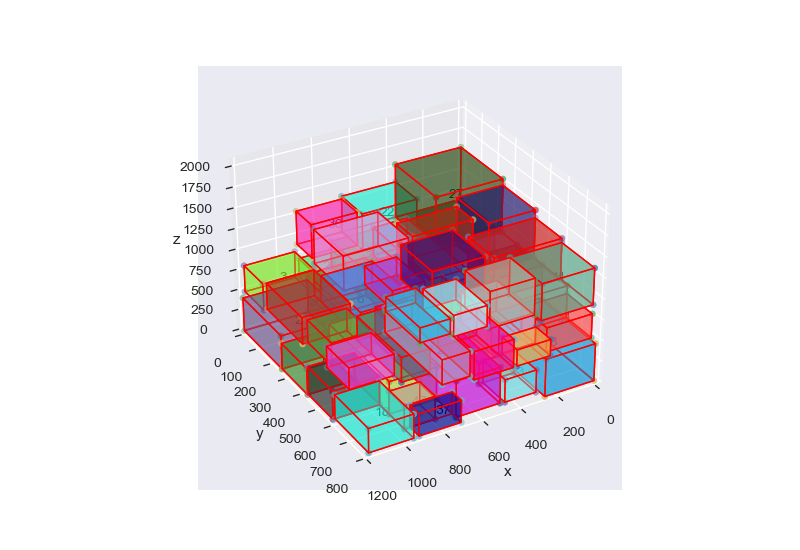

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [54]:
cg_bin_pool = bins.BinPool(cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

## Comparison

In [55]:
print("\tCG")
print("Bin Heights:", cg_bin_pool.get_heights())
print()
print("Bin Densities:", cg_bin_pool.get_bin_densities())
print()
print("Layer Densities:", cg_bin_pool.get_layer_densities(two_dims=False))
print()
print("\tMR")
print("Bin Heights:", mr_bin_pool.get_heights())
print()
print("Bin Densities:", mr_bin_pool.get_bin_densities())
print()
print("Layer Densities:", mr_layer_pool.get_densities(two_dims=False))

	CG
Bin Heights: [1543]

Bin Densities: [0.45399603862530413]

Layer Densities: [[0.7665031465665977, 0.7084644678776683, 0.4206487241972477]]

	MR
Bin Heights: [1715]

Bin Densities: [0.45399603862530413]

Layer Densities: [0.5825106731014271, 0.5504133117816092, 0.48390885308385306]


<IPython.core.display.Javascript object>